In [2]:
if (!require("xfun")) install.packages("xfun")
pkgs = c(
  'forecast', 'vars', 'urca', 'MLmetrics', 
  'lubridate', 'tsbox', 'timetk',
  'patchwork', 'hrbrthemes', 'ggthemes', 'ggsci', 'scales', 
  'tidyverse', 'readxl', 'writexl'
)
xfun::pkg_attach2(pkgs, message = FALSE)

options(
  repr.plot.width=10, 
  repr.plot.height=6, 
  repr.plot.res = 300,
  repr.matrix.max.rows = 10,
  repr.matrix.max.cols = Inf
)

## Data Prep

### Production

In [3]:
production = read_excel('../data/rice_production.xlsx', 'all')

production_annual = production %>% 
  group_by(year, rice_type) %>%
  summarize(area_plant = sum(area_plant),
            area_harvest = sum(area_harvest),
            production = sum(production)*0.66 # convert to milled rice
           ) %>%
  mutate(yield_plant = production*1000/area_plant,
         yield_harvest = production*1000/area_harvest,
        ) %>% ungroup()

production_wide = production_annual %>%
  pivot_wider(
    year,
    rice_type,
    values_from = production
  )

names(production_wide) = c(
  'year_th', 'q_pathum', 'q_hommali', 'q_white', 'q_glutinous'
)

production_wide %>% tail()

`summarise()` regrouping output by 'year' (override with `.groups` argument)



year_th,q_pathum,q_hommali,q_white,q_glutinous
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2557,1037038.2,5693006,12490115,5042944
2558,737410.7,5764920,9656676,4708132
2559,664396.3,5796894,7492643,4143932
2560,919589.2,6125247,9470159,4510751
2561,865119.4,5982158,10568502,4297496
2562,1140052.3,5860384,10237382,4111937


### Export

In [4]:
export = read_rds('../data/export_1006_master.rds')
export_meta = read_excel('../data/meta_hs1006_th.xlsx')
export_joined = export %>% left_join(export_meta, by = c('hscode' = 'hscode'))

export_annual = export_joined %>% 
  group_by(year_th, varities) %>%
  summarize(vol = sum(vol)) %>% ungroup()

export_wide = export_annual %>%
  pivot_wider(
    year_th,
    varities,
    values_from = vol
  )

names(export_wide) = c(
  'year_th', 'ex_glutinous', 'ex_white', 
  'ex_hommali', 'ex_pathum', 'ex_colored'
)

head(export_wide)

export_monthly = export_joined %>% 
  group_by(year_th, month, varities) %>%
  summarize(vol = sum(vol)) %>% ungroup()

export_wide_m = export_monthly %>%
  pivot_wider(
    c(year_th, month),
    varities,
    values_from = vol,
    values_fill = 0
  ) %>% filter(year_th >= 2545)

names(export_wide_m) = c(
  'year_th', 'month',
  'ex_glutinous','ex_white','ex_hommali','ex_pathum','ex_colored'
)

`summarise()` regrouping output by 'year_th' (override with `.groups` argument)



year_th,ex_glutinous,ex_white,ex_hommali,ex_pathum,ex_colored
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2541,153566.6,6386668,NA,NA,NA
2542,312107.4,6526685,NA,NA,NA
2543,197486.1,5943855,NA,NA,NA
2544,210633.5,7352968,121449.1,NA,NA
2545,229807.2,5611646,1492995.0,NA,NA
2546,294417.4,4848814,2202739.0,NA,NA


`summarise()` regrouping output by 'year_th', 'month' (override with `.groups` argument)



### Domestic Consumption

In [5]:
data_m = export_wide_m %>% 
  mutate(date = as.Date(paste0(year_th-543, '-', month, '-1')))

# data_a = export_wide %>% 
#   left_join(production_wide, by = 'year_th') %>%
#   mutate(dom_hommali = q_hommali - ex_hommali,
#          dom_pathum = q_pathum - ex_pathum,
#          dom_white = q_white - ex_white,
#          dom_glutinous = q_glutinous - ex_glutinous
#         ) %>%
#   filter(year_th >= 2545)

# save in csv format
# data_a %>% write_excel_csv('../data/rice_a.csv')
data_m %>% write_excel_csv('../data/rice_m.csv')

### Read

In [13]:
rice_a = read_csv('../data/rice_a.csv') 
rice_m = read_csv('../data/rice_m.csv')
rice_m_ts = rice_m %>% tk_ts(start = 2545-543, frequency = 12)

price = read_csv("../data/price_rice.csv") %>%
  filter(year(date) < 2020)
price_ts = price %>% tk_ts(start = 2000, frequency = 12)

exo = read_csv("../data/wdi_exo.csv")
exo_ts = exo %>% tk_ts(start = 2002, frequency = 1)

data = ts_c(rice_m_ts, price_ts, exo_ts) %>% window(start = 2003)

data = data %>% na.locf()


-- Column specification ----------------------------------------------------------------------------------------------------
cols(
  year_th = col_character(),
  ex_glutinous = col_double(),
  ex_white = col_double(),
  ex_hommali = col_double(),
  ex_pathum = col_double(),
  ex_colored = col_double(),
  q_pathum = col_number(),
  q_hommali = col_number(),
  q_white = col_number(),
  q_glutinous = col_number(),
  dom_hommali = col_double(),
  dom_pathum = col_double(),
  dom_white = col_double(),
  dom_glutinous = col_double()
)



-- Column specification ----------------------------------------------------------------------------------------------------
cols(
  year_th = col_double(),
  month = col_character(),
  ex_glutinous = col_double(),
  ex_white = col_double(),
  ex_hommali = col_double(),
  ex_pathum = col_double(),
  ex_colored = col_double(),
  date = col_date(format = "")
)


Warning message:
"Non-numeric columns being dropped: month, date"

-- Column specification -------

In [14]:
data %>% head

,year_th,ex_glutinous,ex_white,ex_hommali,ex_pathum,ex_colored,p_w25_ind,p_w25_vn,p_w25_th,p_h100_th,p_w5_th,p_w5_vn,gdppc,pop
Jan 2003,2546,28913.08,356512.1,214285.4,0,0,150,160.8,176.80,336.80,197.60,172.40,6131,6351882361
Feb 2003,2546,36102.66,331690.2,213064.3,0,0,150,160.5,176.25,354.50,195.75,171.00,6131,6351882361
Mar 2003,2546,21208.23,209365.2,171172.6,0,0,150,162.0,171.75,438.00,193.25,173.00,6131,6351882361
Apr 2003,2546,29292.17,285458.5,155735.7,0,0,155,163.0,171.00,441.67,193.00,175.33,6131,6351882361
May 2003,2546,25414.69,361081.4,151961.6,0,0,161,168.2,172.80,460.00,195.60,185.40,6131,6351882361
Jun 2003,2546,19855.80,280414.5,167154.9,0,0,175,163.5,179.50,485.50,201.25,183.25,6131,6351882361


## Data Visualization

Warning message:
"Removed 3 row(s) containing missing values (geom_path)."
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Warning message:
"Removed 3 row(s) containing missing values (geom_path)."
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family not found in Windows font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family not found in Windows font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in gri

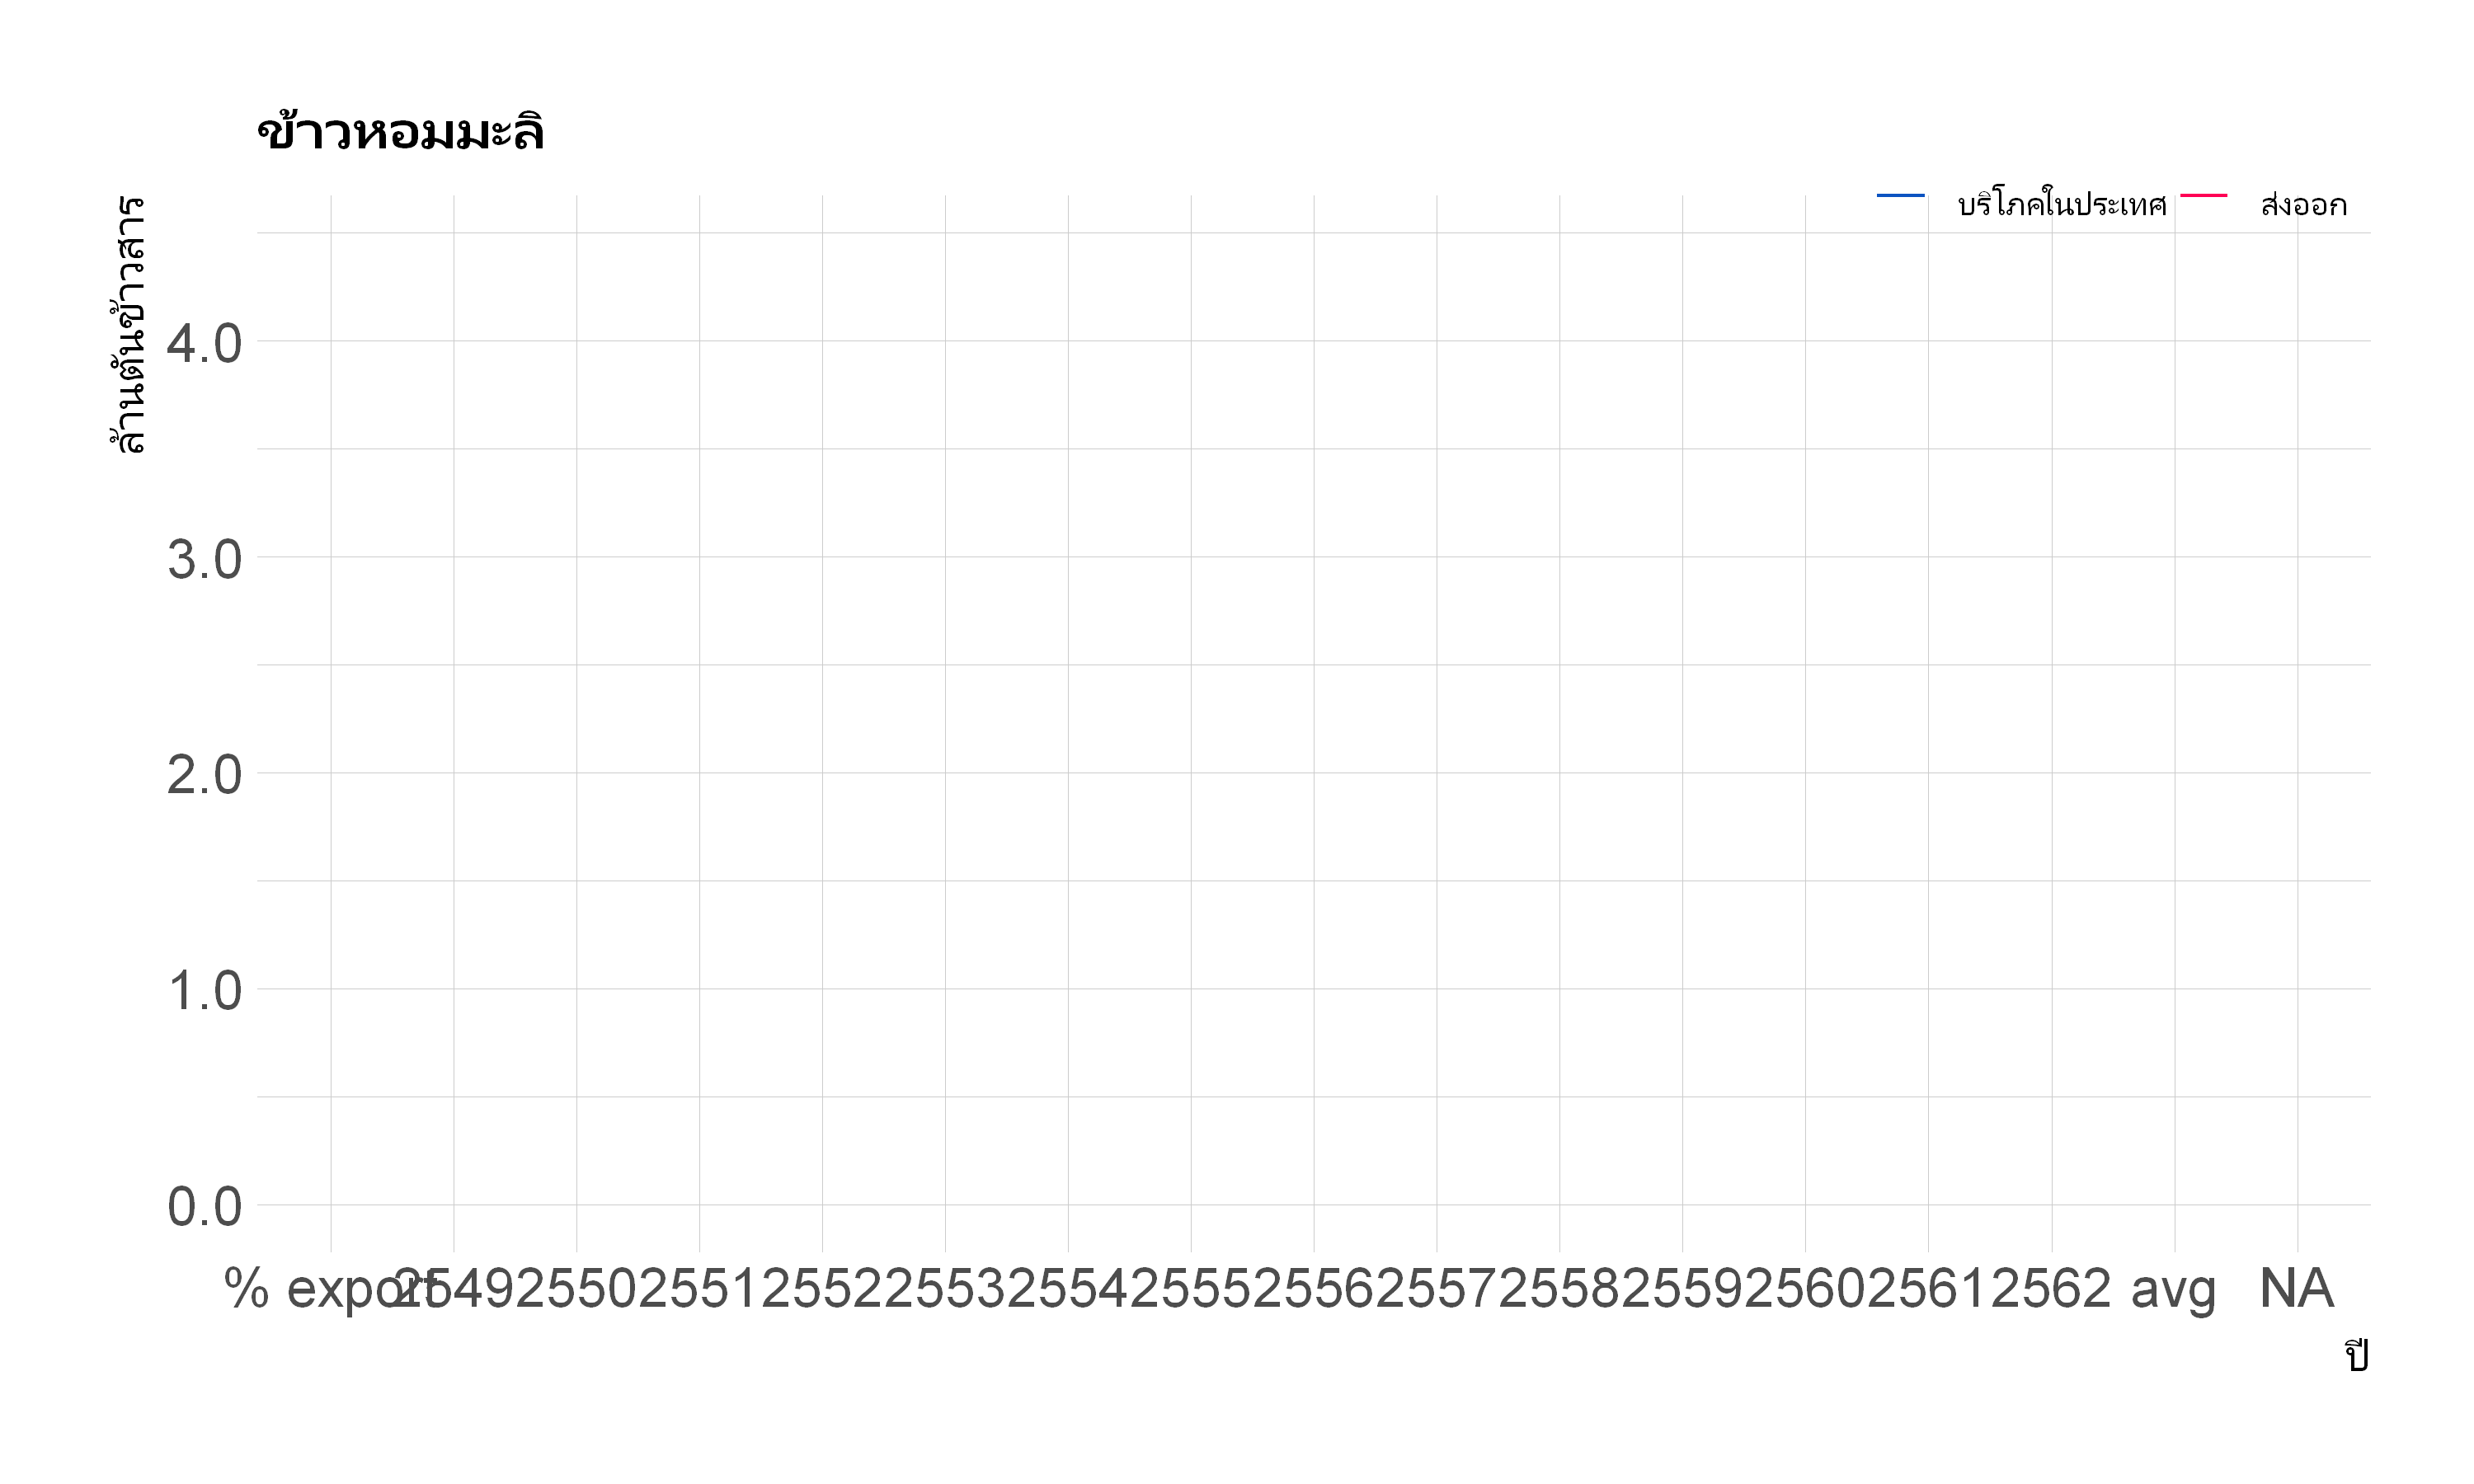

In [15]:
p_hommali = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_hommali/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_hommali/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวหอมมะลิ',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_hommali
ggsave('../figures/plot_hommali.png', width = 8, height = 4)

Warning message:
"Removed 3 row(s) containing missing values (geom_path)."
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Warning message:
"Removed 3 row(s) containing missing values (geom_path)."
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font datab

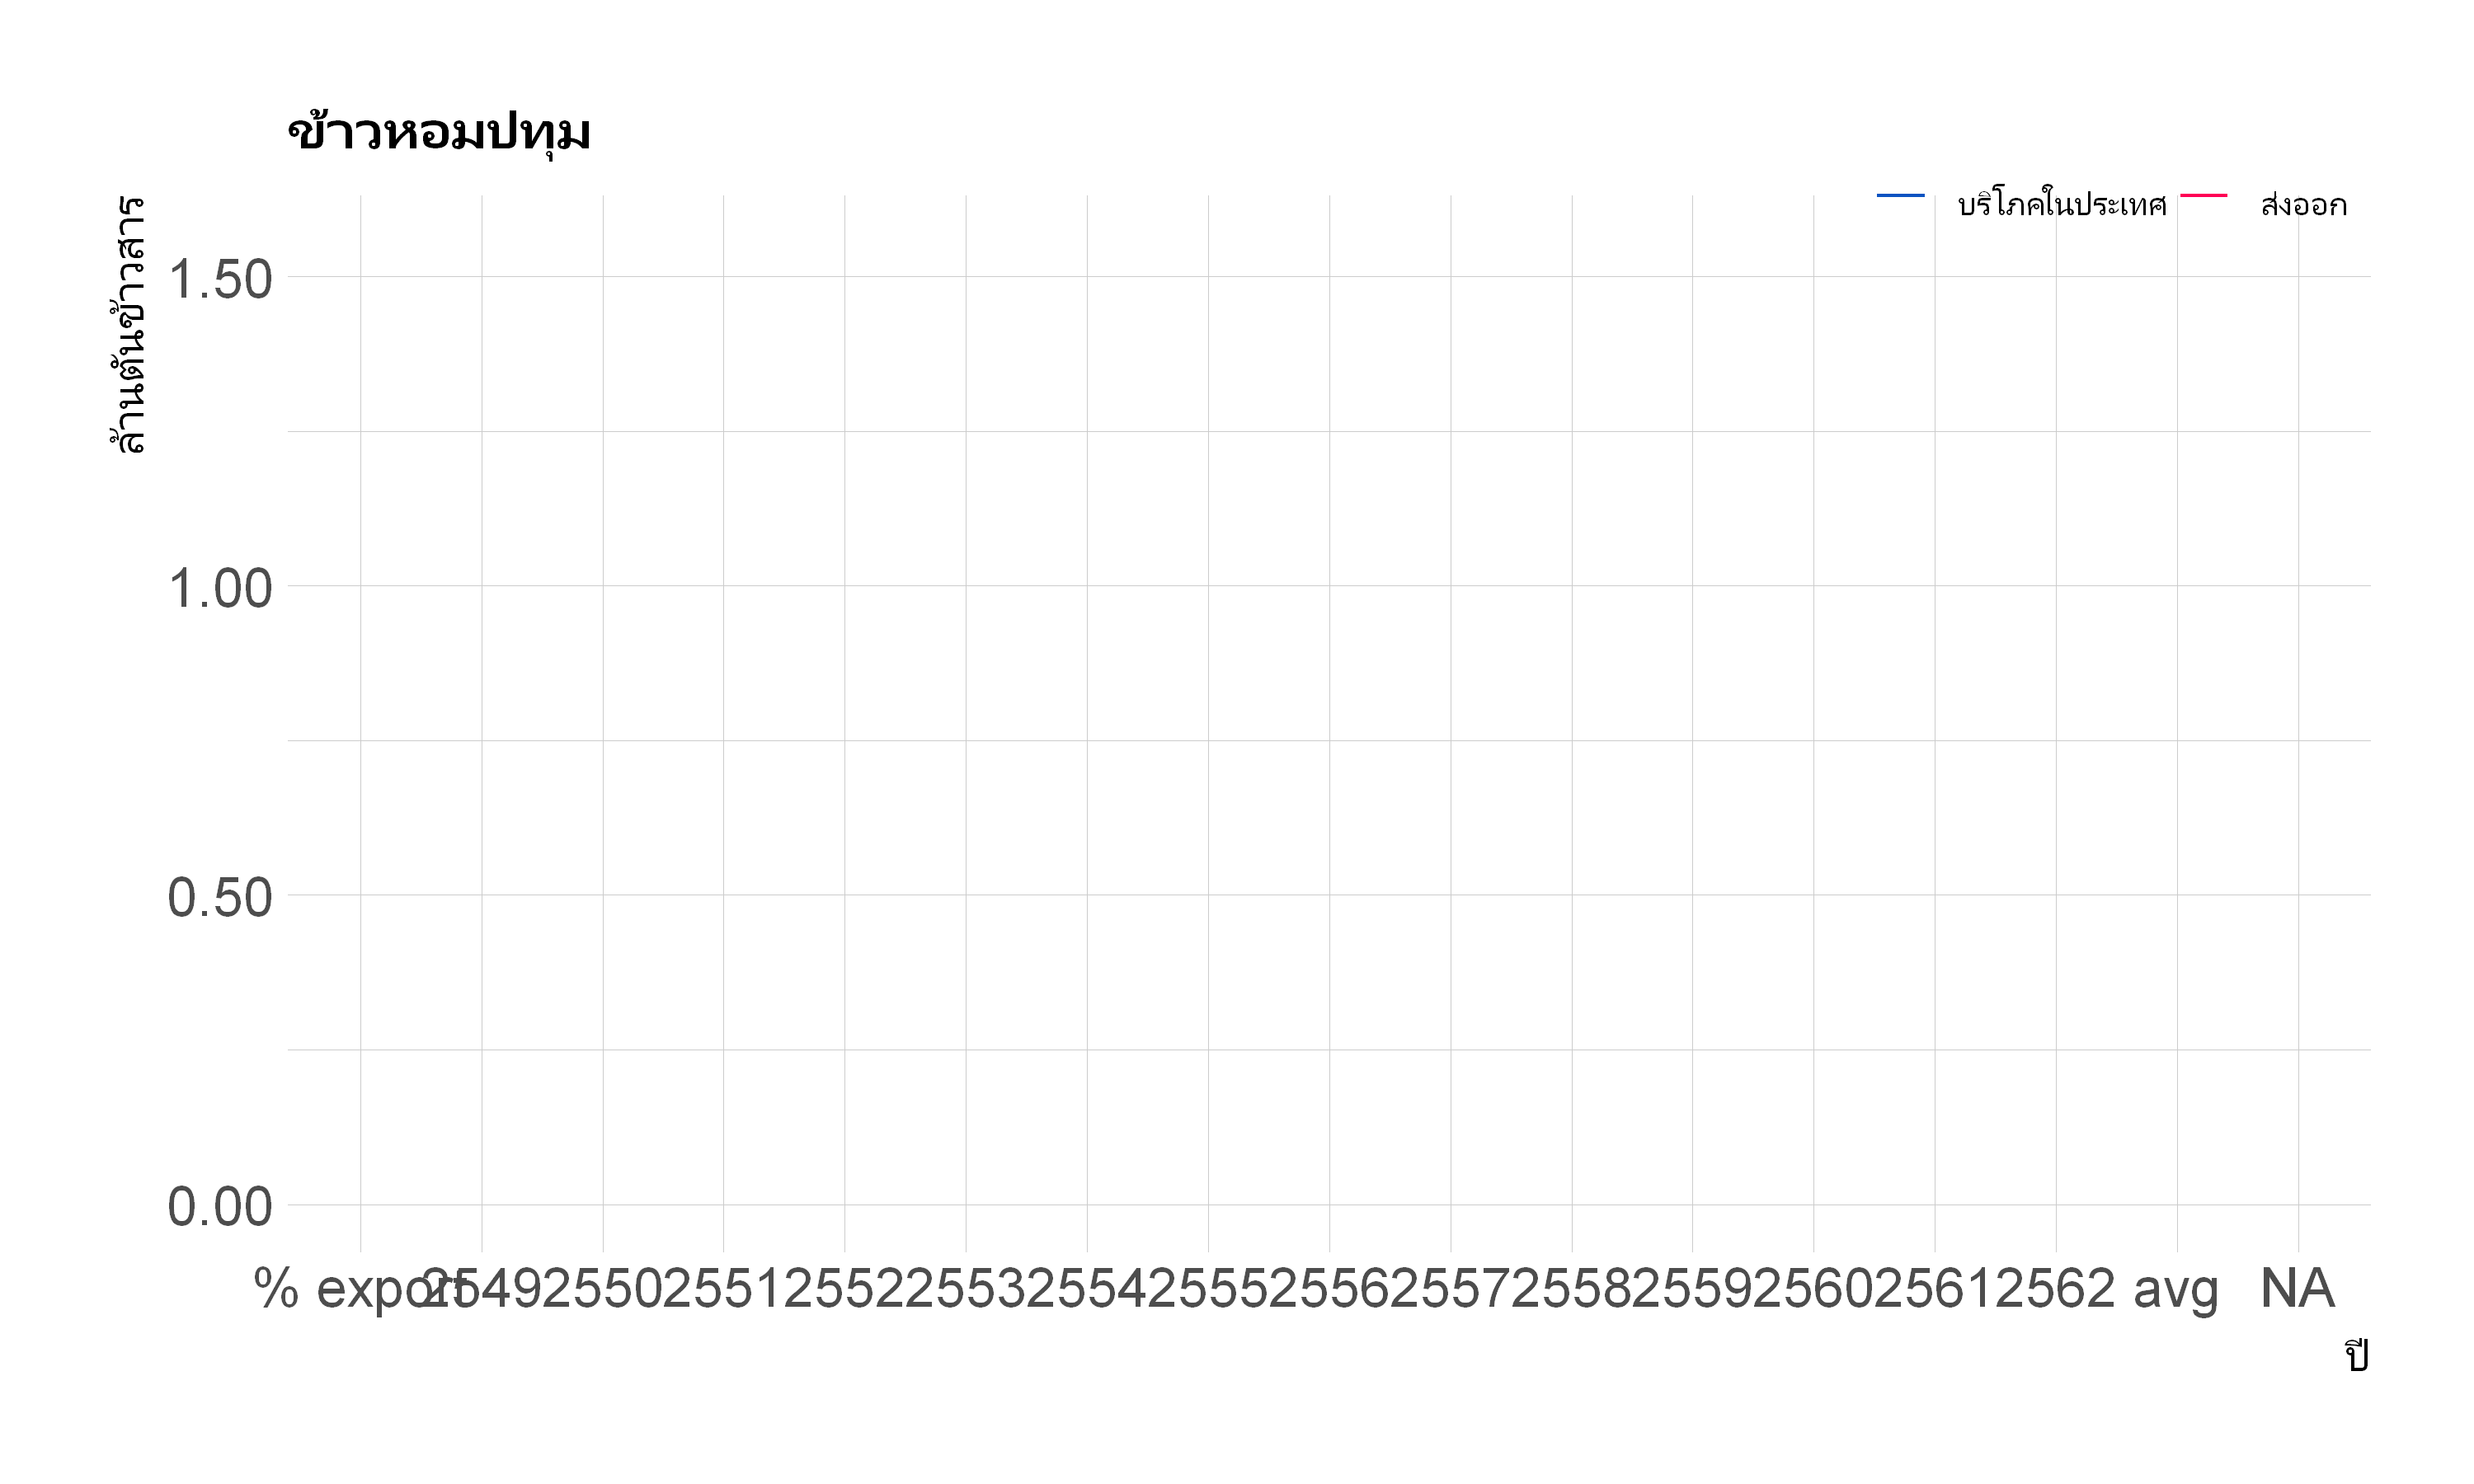

In [16]:
p_pathum = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_pathum/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_pathum/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวหอมปทุม',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_pathum
ggsave('../figures/plot_pathum.png', width = 8, height = 4)

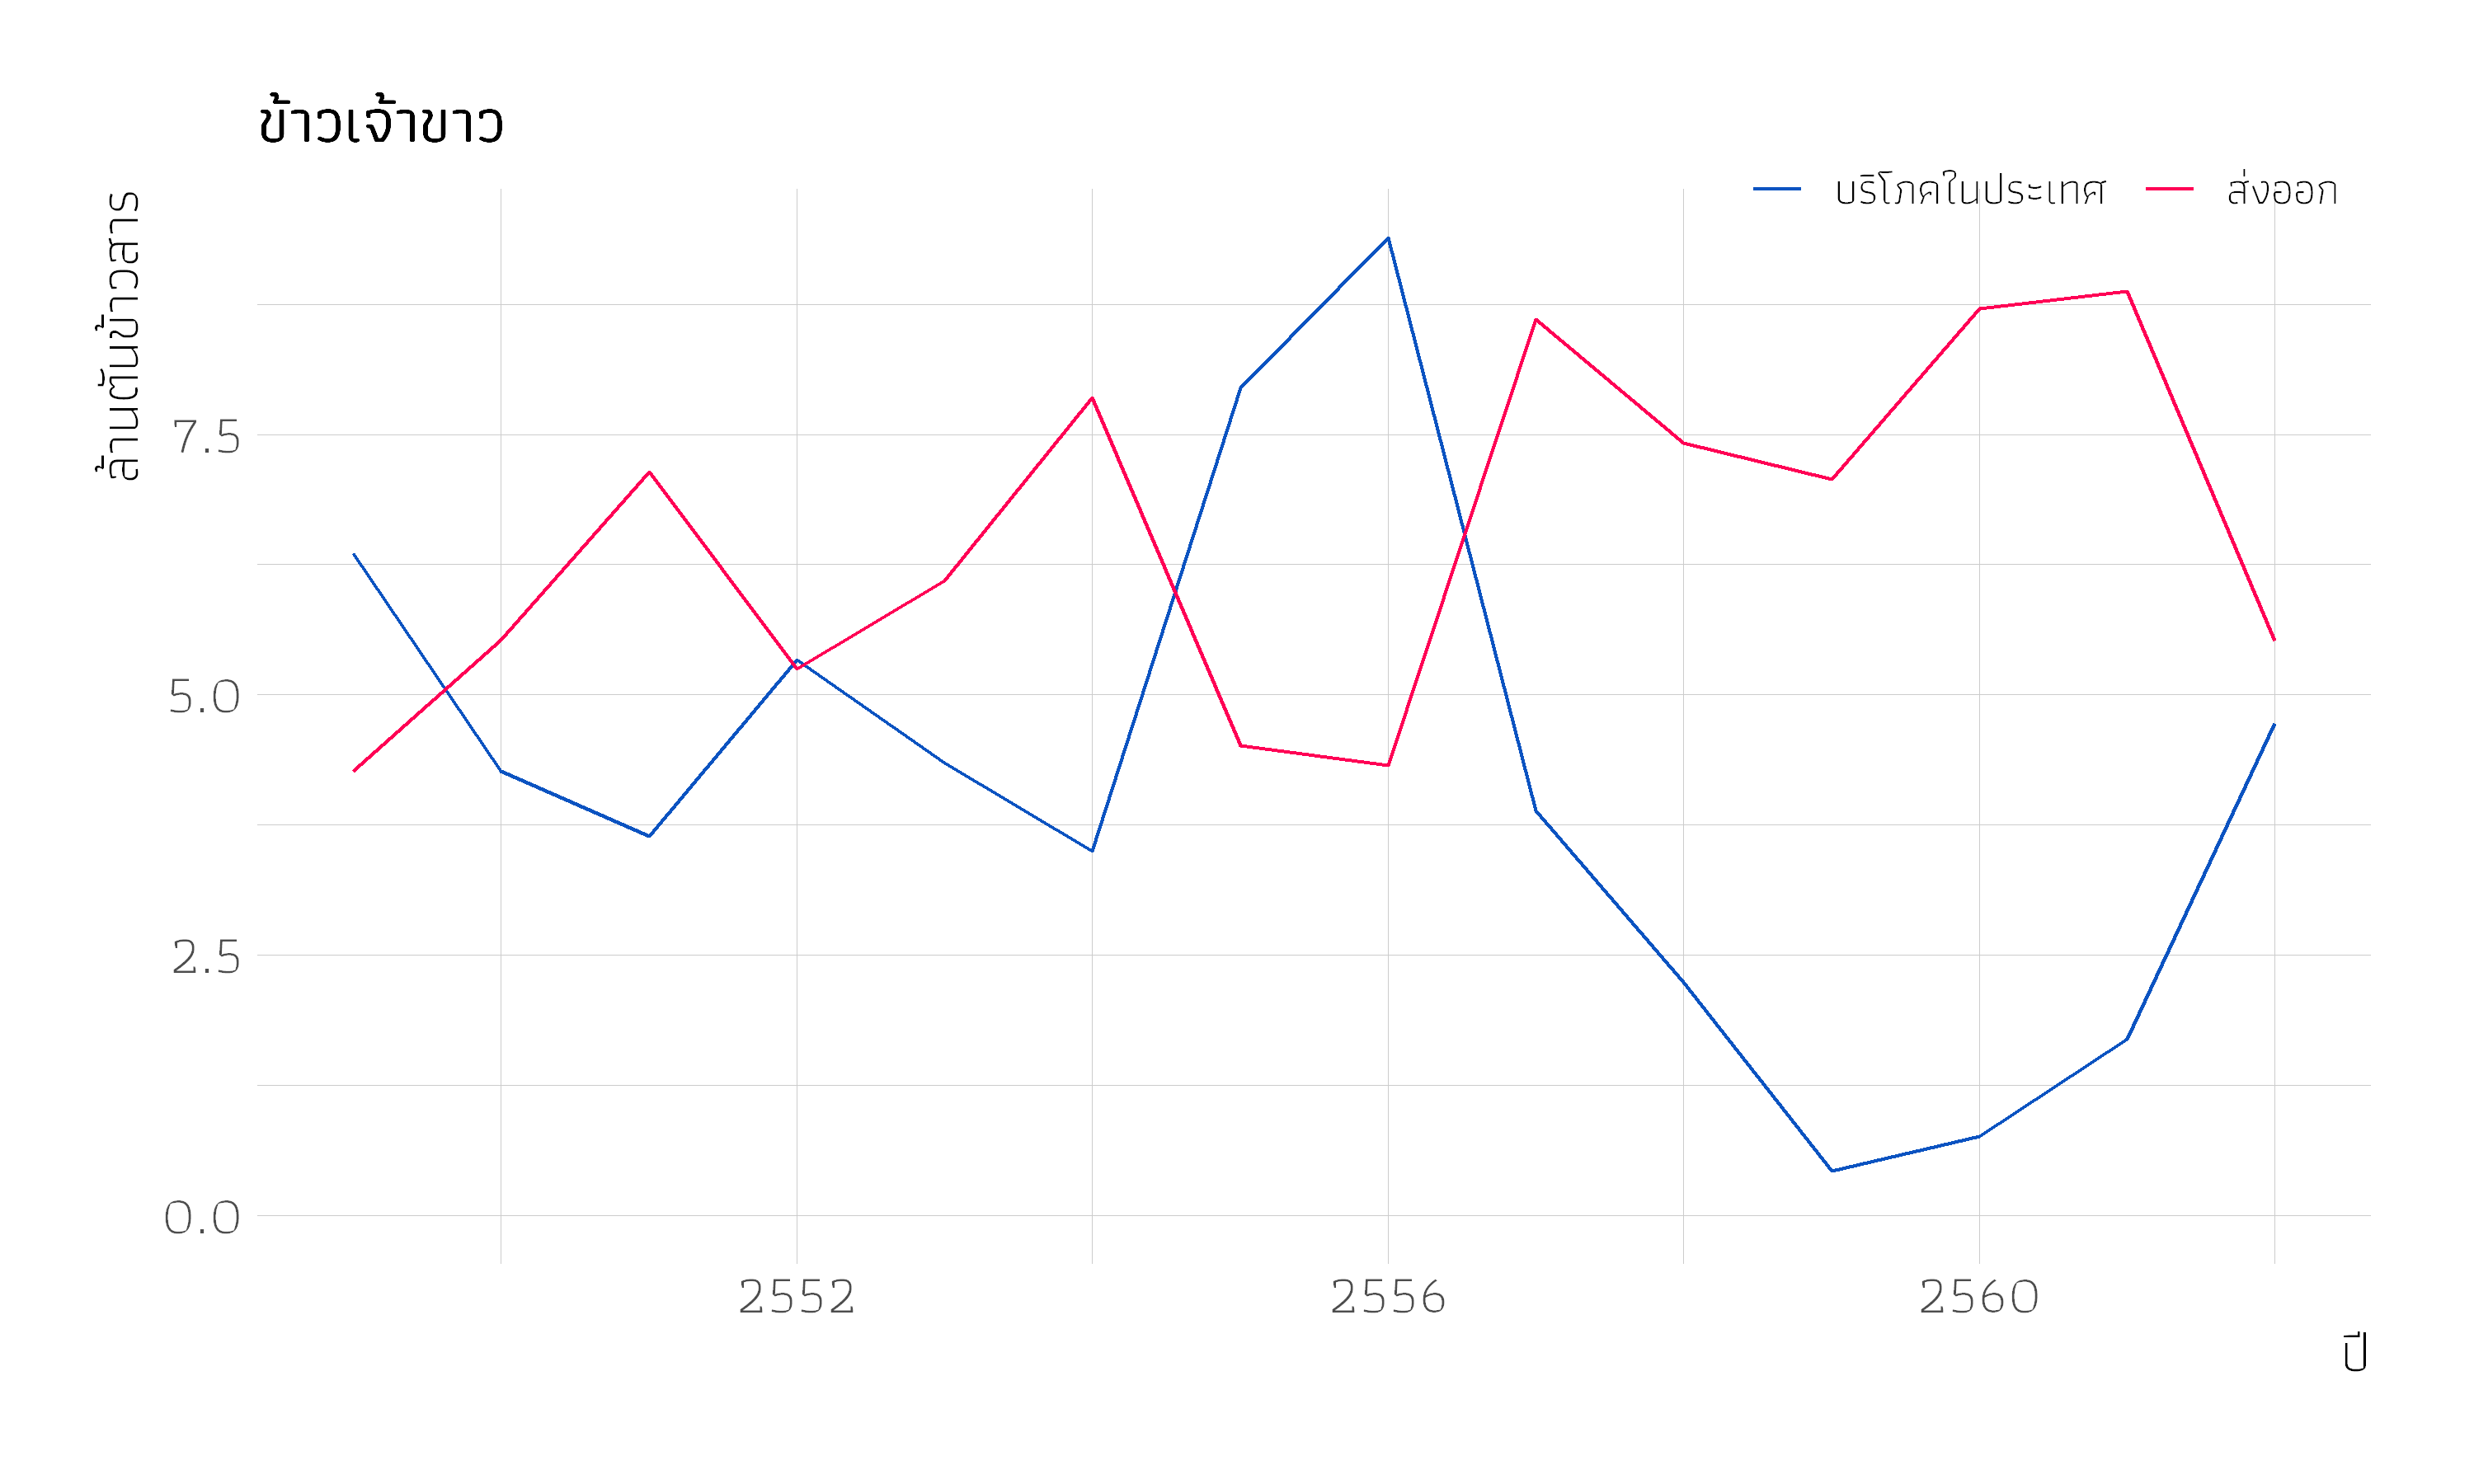

In [38]:
p_white = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_white/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_white/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวเจ้าขาว',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_white
ggsave('../figures/plot_white.png', width = 8, height = 4)

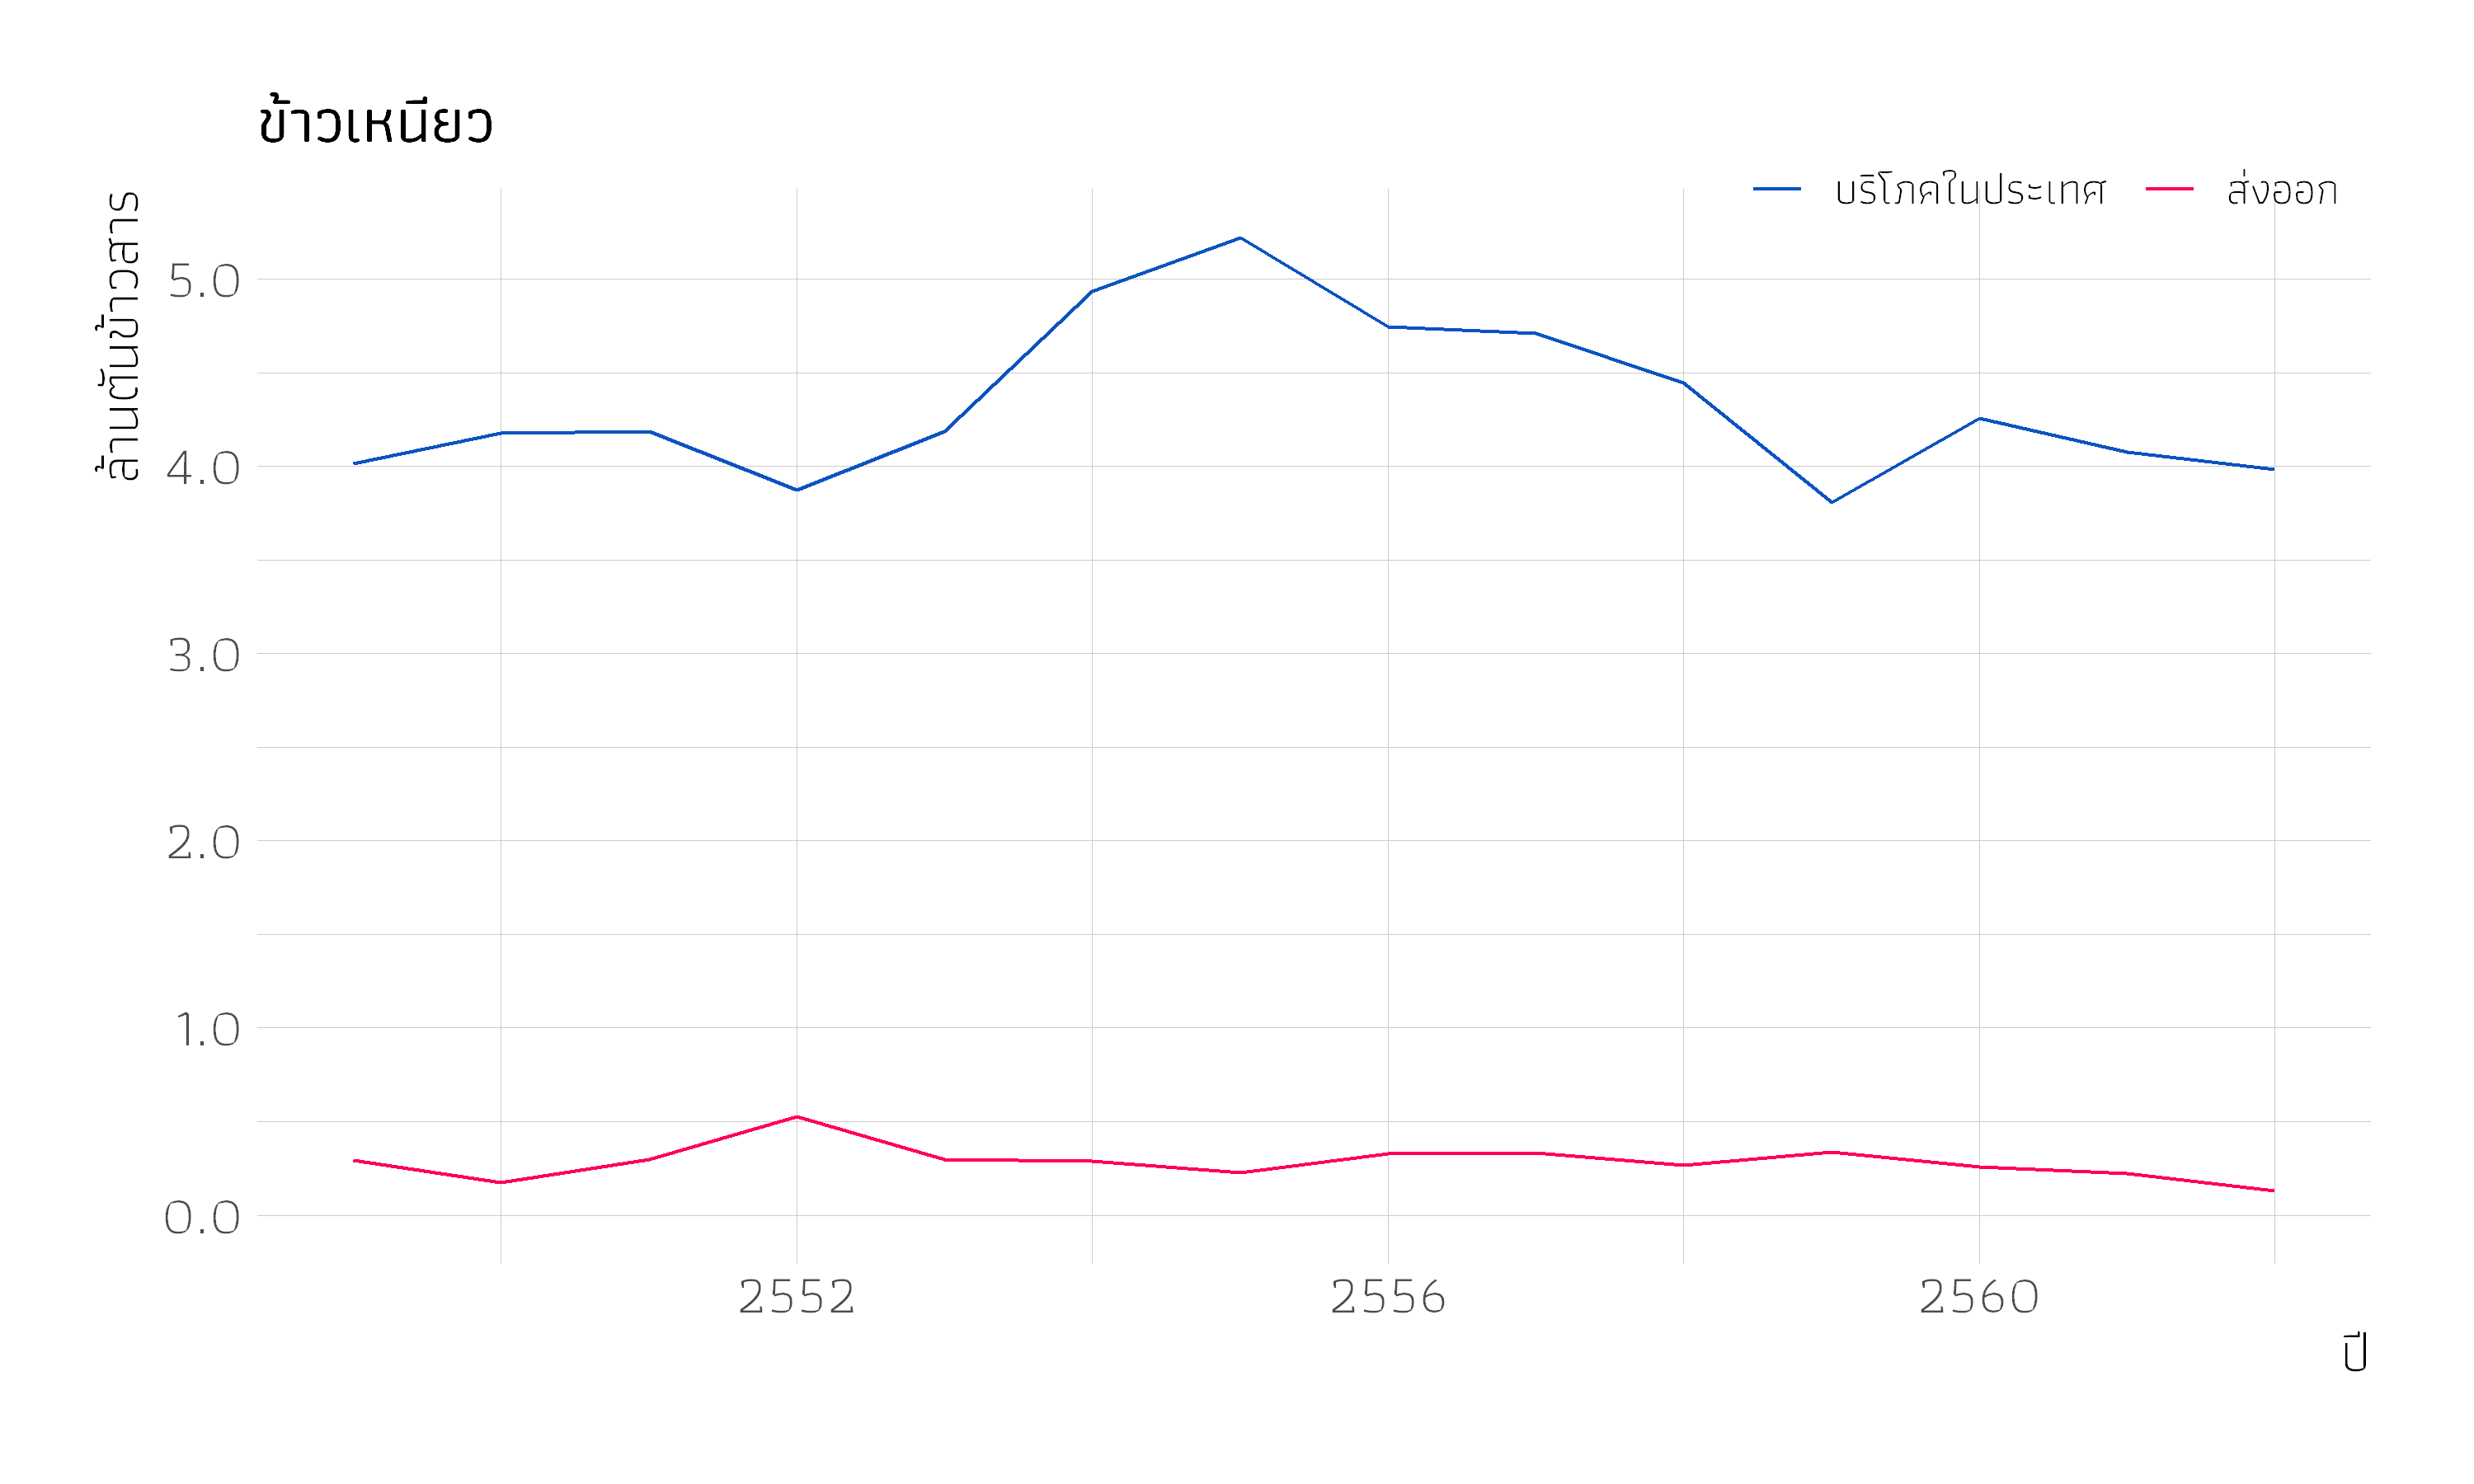

In [39]:
p_glutinous = ggplot(rice_a, aes(x=year_th)) +
  geom_line( aes(y=dom_glutinous/1e6, color = 'Domestic')) + 
  geom_line( aes(y=ex_glutinous/1e6, color = 'Export')) + 
  scale_colour_manual("",
                      label = c('บริโภคในประเทศ', 'ส่งออก'),
                      breaks = c("Domestic", "Export"),
                      values = c("Domestic"="#0b53c1", 
                                 "Export"="#ff0055")
                     ) +
  labs(title = 'ข้าวเหนียว',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  )

p_glutinous
ggsave('../figures/plot_glutinous.png', width = 8, height = 4)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, 

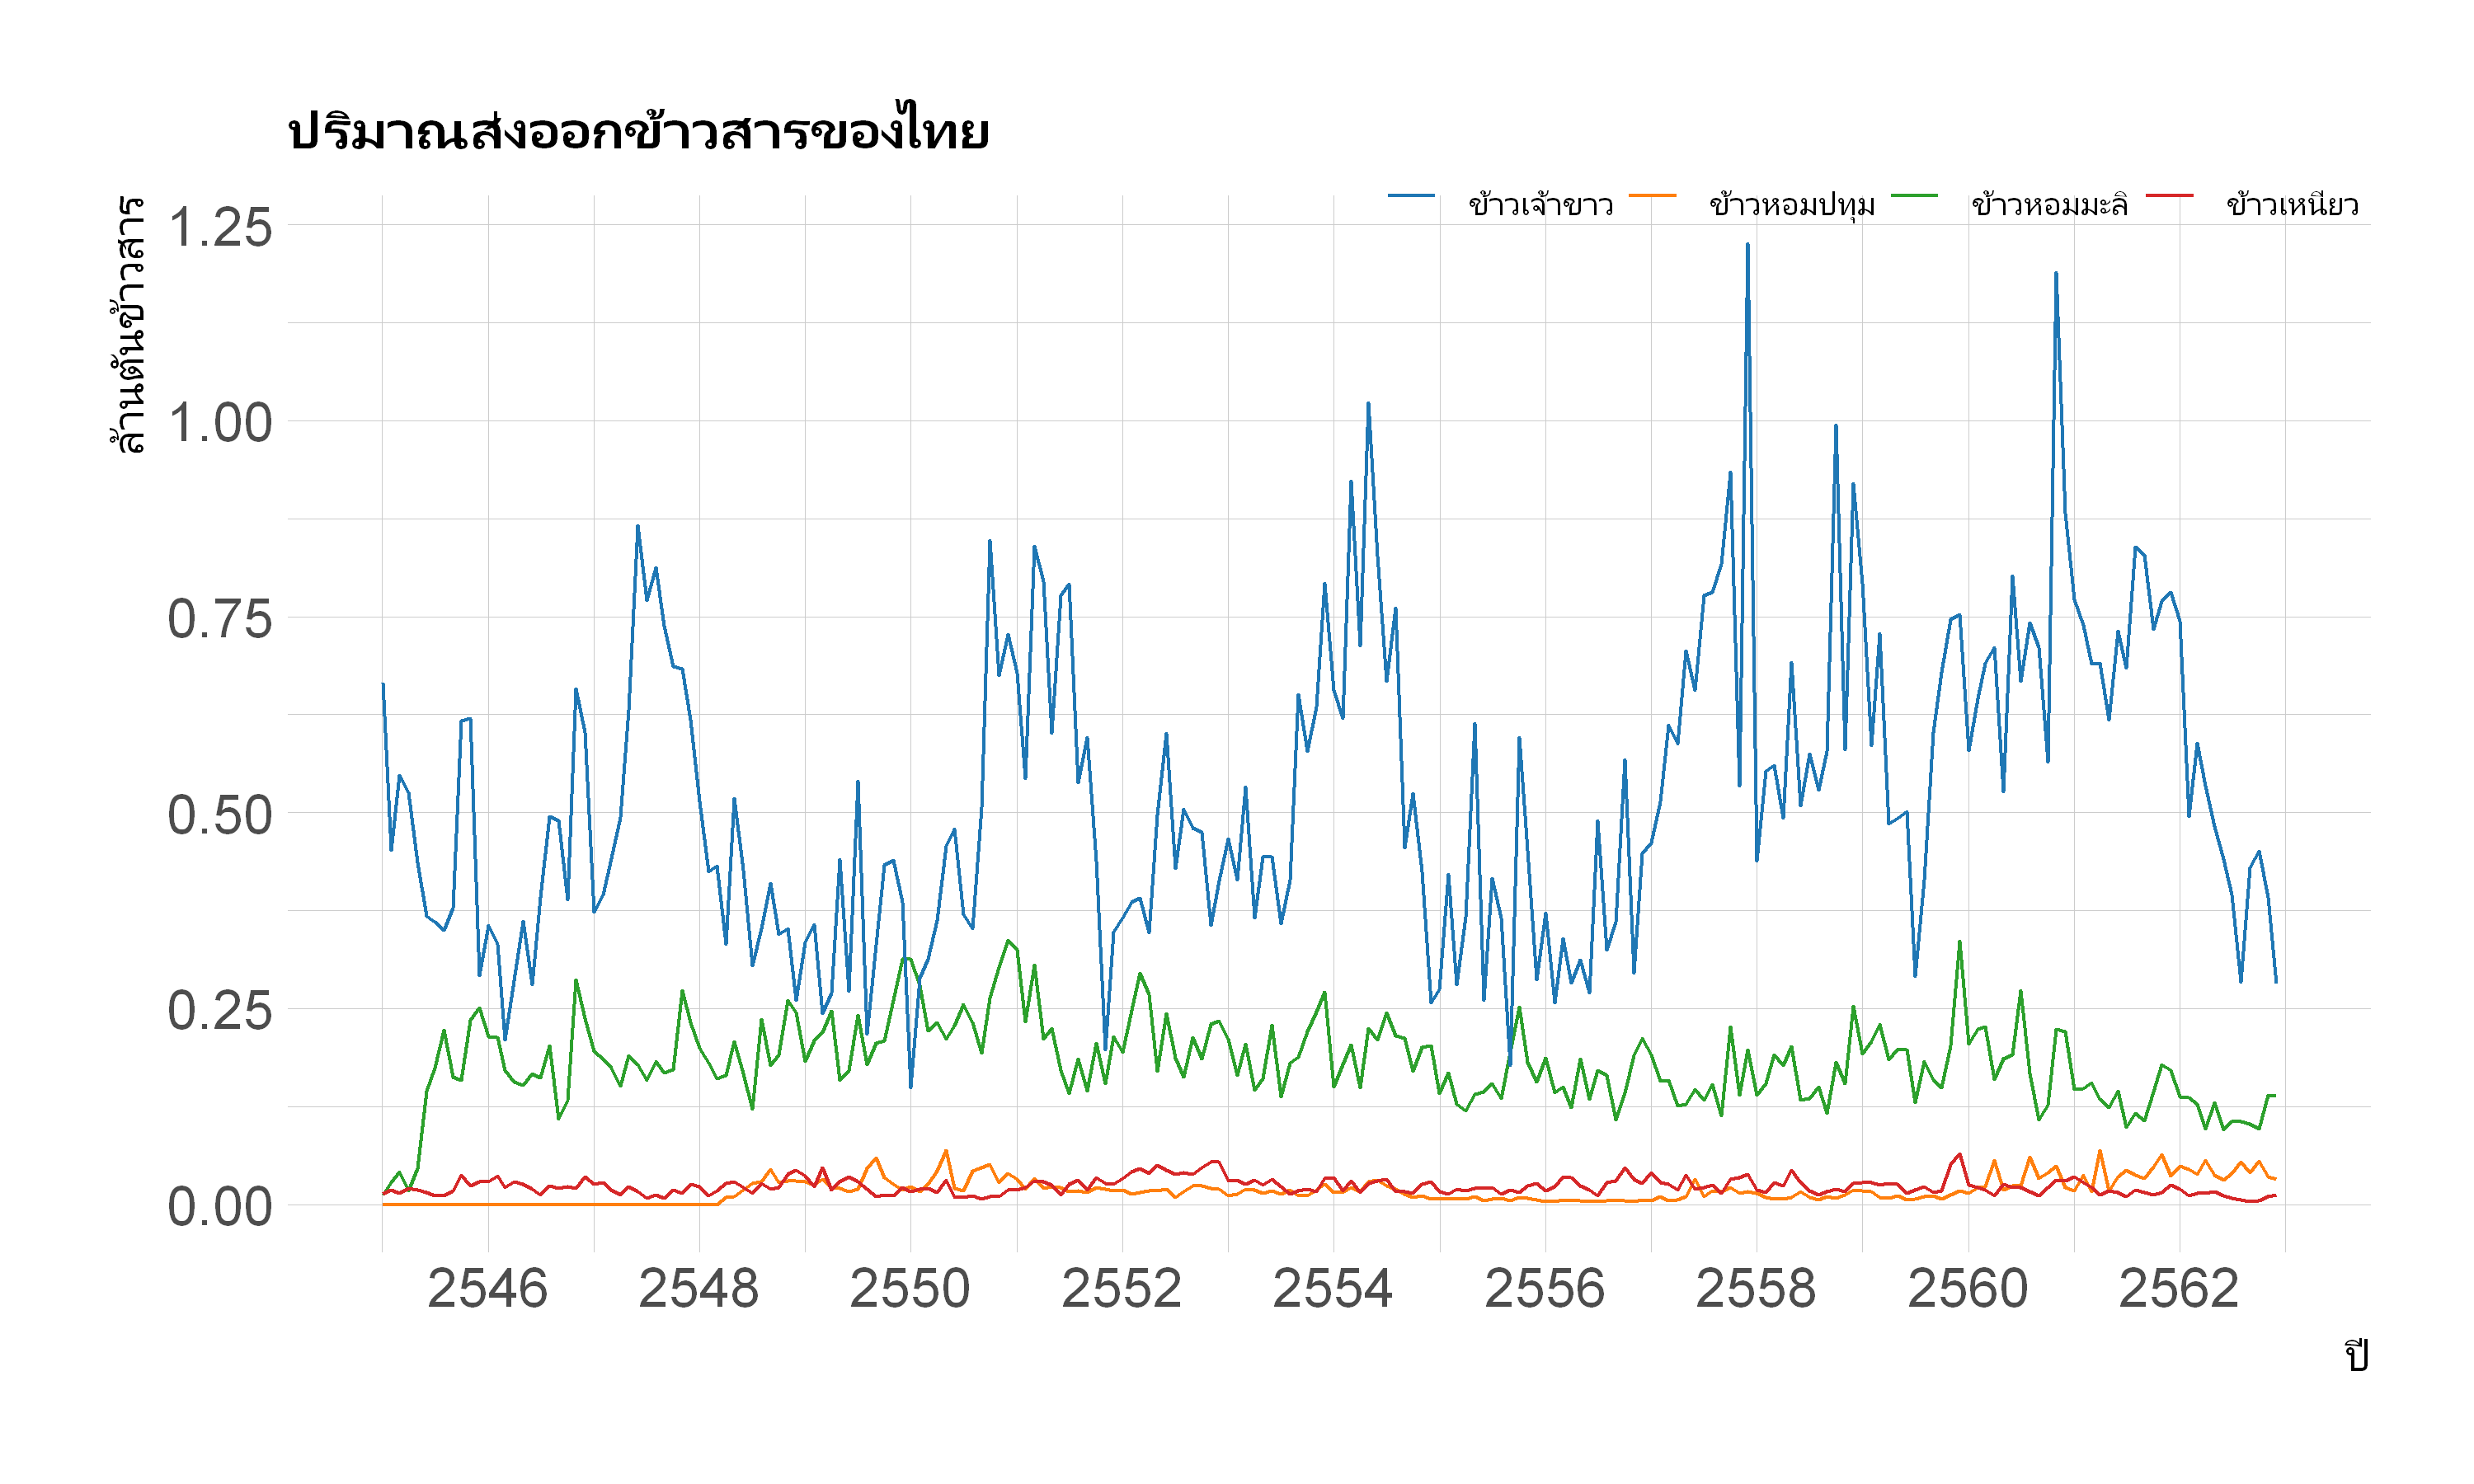

In [17]:
ggplot(rice_m, aes(x=date)) +
  geom_line( aes(y=ex_hommali/1e6, color = 'ข้าวหอมมะลิ')) +
  geom_line( aes(y=ex_pathum/1e6, color = 'ข้าวหอมปทุม')) +
  geom_line( aes(y=ex_white/1e6, color = 'ข้าวเจ้าขาว')) +
  geom_line( aes(y=ex_glutinous/1e6, color = 'ข้าวเหนียว')) +
  scale_color_d3() +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  labs(title = 'ปริมาณส่งออกข้าวสารของไทย',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  ) +
  scale_x_date(date_breaks = '2 years',
               labels = function(x) year(x)+543
               )

ggsave('../figures/plot_export_m.png', width = 10, height = 7)

## Unit Root Test

In [18]:
get_objname = function(x) deparse(substitute(x))

ur_adf = function(y, n_diff = 0, varname = NULL, ...) {
  
  varname = if (is.null(varname)) deparse(substitute(y)) else varname
  y = if(n_diff == 0) y else diff(y, n_diff)
  
  ur.trend = ur.df(y, type='trend', selectlags = "AIC", ...)
  ur.drift = ur.df(y, type='drift', selectlags = "AIC", ...)
  ur.none  = ur.df(y, type='none', selectlags = "AIC", ...)

  tstat.trend = ur.trend@teststat
  tstat.drift = ur.drift@teststat
  tstat.none  = ur.none@teststat

  cv.trend = ur.trend@cval
  cv.drift = ur.drift@cval
  cv.none  = ur.none@cval

  df_test = rbind(
    cbind(t(tstat.trend), cv.trend),
    cbind(t(tstat.drift), cv.drift),
    cbind(t(tstat.none) , cv.none)
  ) %>% 
  as.data.frame() %>%
  rownames_to_column("hypo") %>%
  mutate(
    result = ifelse(abs(statistic) >= abs(`5pct`), 'Reject', 'Accept'),
    variable = varname,
    level = paste0('d', n_diff),
    statistic = round(statistic, 2),
  ) %>%
  filter(str_starts(hypo, 'tau')) %>%
  select(variable, hypo, level, everything())
  
  return(df_test)
}

In [19]:
ex_hommali = data[, 'ex_hommali'] %>% log()
ex_white = data[, 'ex_white'] %>% log()
p_w5_th = data[, 'p_w5_th'] %>% log()
p_w5_vn = data[, 'p_w5_vn'] %>% log()
p_h100_th = data[, 'p_h100_th'] %>% log()
gdppc = data[, 'gdppc'] %>% log()
pop = data[, 'pop'] %>% log()

vars_list = list(
  ex_hommali = ex_hommali, 
  ex_white = ex_white, 
  p_w5_th = p_w5_th, 
  p_w5_vn = p_w5_vn, 
  p_h100_th = p_h100_th,
  gdppc = gdppc, 
  pop = pop
)

varnames = rep(names(vars_list), 2)

params = expand_grid(varnames, c(0,1)) %>%
  set_names(c('names', 'ndiff')) %>%
  mutate(ser = vars_list[names])

pmap(list(params$ser, params$ndiff, params$names), 
     function(first, second, third) {
       ur_adf(first, second, third)
     }) %>% 
  reduce(rbind) %>% 
  write_excel_csv('../results/adf_table.csv') %>%
  print()

# rbind(
#   ur_adf(ex_hommali, 0)   , ur_adf(ex_hommali, 1),
#   ur_adf(ex_white, 0)     , ur_adf(ex_white, 1),
#   ur_adf(p_w5_th, 0)      , ur_adf(p_w5_th, 1),
#   ur_adf(p_w5_vn, 0)      , ur_adf(p_w5_vn, 1),
#   ur_adf(p_h100_th, 0)    , ur_adf(p_h100_th, 1)
# ) %>% print()

     variable hypo level statistic  1pct  5pct 10pct result
1  ex_hommali tau3    d0     -6.18 -3.99 -3.43 -3.13 Reject
2  ex_hommali tau2    d0     -5.32 -3.46 -2.88 -2.57 Reject
3  ex_hommali tau1    d0     -0.28 -2.58 -1.95 -1.62 Accept
4  ex_hommali tau3    d1    -14.86 -3.99 -3.43 -3.13 Reject
5  ex_hommali tau2    d1    -14.90 -3.46 -2.88 -2.57 Reject
6  ex_hommali tau1    d1    -14.93 -2.58 -1.95 -1.62 Reject
7    ex_white tau3    d0     -4.36 -3.99 -3.43 -3.13 Reject
8    ex_white tau2    d0     -4.23 -3.46 -2.88 -2.57 Reject
9    ex_white tau1    d0     -0.14 -2.58 -1.95 -1.62 Accept
10   ex_white tau3    d1    -16.37 -3.99 -3.43 -3.13 Reject
11   ex_white tau2    d1    -16.36 -3.46 -2.88 -2.57 Reject
12   ex_white tau1    d1    -16.40 -2.58 -1.95 -1.62 Reject
13    p_w5_th tau3    d0     -2.42 -3.99 -3.43 -3.13 Accept
14    p_w5_th tau2    d0     -2.57 -3.46 -2.88 -2.57 Accept
15    p_w5_th tau1    d0      0.51 -2.58 -1.95 -1.62 Accept
16    p_w5_th tau3    d1     -8.08 -3.99

## Define function

In [29]:
ex_hommali %>% subset(end = 12*14)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2003,12.27506,12.26935,12.05043,11.95592,11.93138,12.02668,11.99204,12.21806,11.59842,11.79892,12.56541,12.37573
2004,12.18385,12.13132,12.06941,11.92308,12.15140,12.09397,11.97000,12.11370,12.02850,12.05778,12.51565,12.35654
2005,12.20028,12.10040,11.98678,12.01373,12.24296,12.02176,11.70544,12.37199,12.08751,12.15995,12.46957,12.40910
2006,12.11371,12.25000,12.29707,12.41546,11.97300,12.05084,12.39497,12.09268,12.23232,12.24751,12.46998,12.65313
2007,12.65482,12.53970,12.30977,12.35325,12.25791,12.33392,12.45028,12.35567,12.17114,12.48272,12.61910,12.72745
2008,12.69003,12.36107,12.63030,12.25981,12.32296,12.04893,11.86086,12.12944,11.88442,12.23491,11.94604,12.27164
2009,12.17636,12.42172,12.59405,12.49948,12.04548,12.40440,12.13824,11.99642,12.27100,12.12971,12.34684,12.36161
2010,12.25799,12.01384,12.22843,11.89214,11.98828,12.34012,11.83289,12.10238,12.14565,12.30094,12.40996,12.50969
2011,11.91711,12.09319,12.22329,11.90842,12.32057,12.25237,12.40825,12.28132,12.26438,12.04506,12.20598,12.21964
2012,11.85914,12.02908,11.76116,11.69006,11.84962,11.87401,11.94425,11.81484,12.17445,12.43721,12.10684,11.96141


In [32]:
14*12

[1] 168

In [102]:
ets_vec = Vectorize(ets)
x = ex_hommali %>% subset(end = 120)
params = list(y = x, model = "ZZZ", damped = FALSE)

# ets(ex_hommali %>% subset(end = 120), params)
res = do.call(ets, params)

In [107]:
# forecast(res, 12)
# ets(ex_hommali %>% subset(end = 120), model = "ZZZ", damped = FALSE) %>% str()

In [12]:
params = list(model = "ZZZ", damped = FALSE)
c(y = "xx", params)

[1] "list"

# Strategy
1. 

In [72]:
params = list(model = "ZZZ", damped = NULL)

ets_fcast = function(i, data, params, h=1) {
  y = data %>% subset(end = i)
  params$y = y
  fitted = do.call(forecast::ets, params)
  res = fitted %>% forecast(h=h) %>% as.data.frame()
  return(res)
}

rolling_ets = function(data, params, n_initial, h) {
  n_sample = length(data)
  res = n_initial:n_sample %>% 
    map(ets_fcast, data = data, params = params, h = h) %>% 
    reduce(rbind)
  return(res)
}

x = rolling_ets(
  ex_hommali, 
  params = list(model = "AAA", damped = TRUE) , 
  n_initial = 168, h = 1)

x

,Point Forecast,Lo 80,Hi 80,Lo 95,Hi 95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sep 2018,11.48445,11.14888,11.82003,10.97123,11.99768
Oct 2018,11.62797,11.24483,12.01111,11.04201,12.21393
Oct 20181,11.68379,11.34930,12.01828,11.17223,12.19535
Nov 2018,11.82779,11.45204,12.20354,11.25313,12.40245
Nov 20181,11.93941,11.60446,12.27437,11.42714,12.45169
...,...,...,...,...,...
Dec 2019,11.80600,11.43325,12.17874,11.23594,12.37605
Dec 20191,11.87710,11.55062,12.20358,11.37779,12.37641
Jan 2020,11.60403,11.23930,11.96877,11.04622,12.16184


In [59]:
# fit function
fets = function(x, model='AAN', damped = FALSE, h=h) {
  forecast::ets(x, model = model, damped = damped) %>% forecast(h=h)
}

fets.auto = function(x, h=h) {
  forecast::ets(x, model = 'ZZZ', damped = NULL) %>% forecast(h=h)
}

farima = function(x, order = c(0,0,0), seasonal = c(0,0,0), h=h) {
  forecast::Arima(x,
                  order = order, 
                  seasonal = seasonal,
                 ) %>% forecast(h=h)
}

farima.auto = function(x, d=0, h=h) {
  forecast::auto.arima(x, d=d) %>% forecast(h=h)
}


# accuracy measurement
rmse = function(data, h = h) {
  data = data %>% select('actual', starts_with('yhat')) %>% exp()
  h = ncol(data) - 1
  for (i in seq(h)) {
    data[, paste0('e', i)] = (
      lead(data[,'actual'], i) - data[, paste0('yhat', i)]
    )^2
  }
  rmse_score = data %>% select(starts_with('e')) %>% 
    as.matrix() %>% mean(na.rm = TRUE) %>% sqrt()
  
  return(rmse_score)
}

mape = function(data, h = h) {
  data = data %>% select('actual', starts_with('yhat')) %>% exp()
  h = ncol(data) - 1
  for (i in seq(h)) {
    data[, paste0('e', i)] = abs(
      lead(data[,'actual'], i) - data[, paste0('yhat', i)]
    )*100 / lead(data[,'actual'], i)
  }
  mape_score = data %>% select(starts_with('e')) %>% 
    as.matrix() %>% mean(na.rm = TRUE)
  
  return(mape_score)
}

eval_ets = function(x, params, h = 2, initial = 11) {
  pmap(
    list(params$model, params$damped), 
    function(first, second) {
      
      # 1 compute forecast error using time series cross validation
      error = tsCV(x, fets, h = h, initial = initial, 
                   model = first, 
                   damped = second
                  ) %>% as.data.frame()
      new_colnames = c('actual', paste0('e', seq(1:h)))
      error = data.frame(x, error) %>% set_names(new_colnames)
      
      # 2 compute predicted (yhat)
      for (i in seq(h)) {
        error[, paste0('yhat', i)] = (
          lead(error[,'actual'], i) - error[, paste0('e', i)]
        )
      }
      
      # 3 compute rmse, mape
      data.frame(
        model = paste(first, second, sep = '-'),
        rmse = rmse(error),
        mape = mape(error)
      ) %>% na.omit()
    }
  ) %>% 
  reduce(bind_rows) %>%
  arrange(rmse)
}

eval_arima = function(x, params, h = 2, initial = 11) {
  pmap(
    list(params$order, params$seasonal), 
    function(first, second) {
      
      # 1 compute forecast error using time series cross validation
      error = tsCV(x, farima, h = h, initial = initial, 
                   order = first, 
                   seasonal = second
                  ) %>% as.data.frame()
      new_colnames = c('actual', paste0('e', seq(1:h)))
      error = data.frame(x, error) %>% set_names(new_colnames)
      
      # 2 compute predicted (yhat)
      for (i in seq(h)) {
        error[, paste0('yhat', i)] = (
          lead(error[,'actual'], i) - error[, paste0('e', i)]
        )
      }
  
      # 3 compute rmse, mape
      data.frame(
        model = paste(paste(first, collapse = ','), 
                      paste(second, collapse = ','), sep = '-'),
        rmse = rmse(error),
        mape = mape(error)
      ) %>% na.omit()
    }
  ) %>% 
  reduce(bind_rows) %>%
  arrange(rmse)
}

## Export

In [7]:
# ETS params
Z1 = c('A','M')
Z2 = c('N', 'A', 'M')
Z3 = c('N', 'A', 'M')
damped = c(FALSE, TRUE)

ets_params = expand.grid(Z1, Z2, Z3, damped) %>%
  mutate(
    model = paste0(Var1, Var2, Var3),
    damped = Var4
) %>% select(model, damped)

# ARIMA params
p = seq(0,2)
q = seq(0,2)
P = seq(0,1)
Q = seq(0,1)

arima_params = expand.grid(p,q,P,Q) %>% rowwise() %>%
  mutate(
    order = pmap(list(Var1, Var2), function(x, y) c(x, 0, y)),
    seasonal = pmap(list(Var3, Var4), function(x, y) c(x, 0, y)),
  ) %>% select(order, seasonal)

In [70]:
(length(ex_hommali)-8) * 0.80 / 12
216-36

[1] 14.4

[1] 180

In [61]:
h = 1
initial = 180

e.ets.ex_hml = eval_ets(
  ex_hommali %>% log(), params = ets_params, h = h, initial = initial
)
e.ets.ex_wht = eval_ets(
  ex_white %>% log(), params = ets_params, h = h, initial = initial
)

In [60]:
e.arima.ex_hml = eval_arima(
  ex_hommali %>% log(), params = arima_params, h = h, initial = initial
)
e.arima.ex_wht = eval_arima(
  ex_white %>% log(), params = arima_params, h = h, initial = initial
)

In [166]:
# acc_ex_hml1 = list(ets = e.ets.ex_hml, e.arima.ex_hml)
# acc_ex_pat1 = list(ets = e.ets.ex_pat, e.arima.ex_pat)
# acc_ex_wht1 = list(ets = e.ets.ex_wht, e.arima.ex_wht)
# acc_ex_glu1 = list(ets = e.ets.ex_glu, e.arima.ex_glu)

In [116]:
acc_ex_hml = list(ets = e.ets.ex_hml %>% head(3), 
                  arima = e.arima.ex_hml %>% head(3))
acc_ex_wht = list(ets = e.ets.ex_wht %>% head(3), 
                  arima = e.arima.ex_wht %>% head(3))

In [117]:
acc_ex_hml

,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,MAA-TRUE,30580.81,14.55500
2,AAA-TRUE,30658.27,14.84307
3,MAA-FALSE,31408.06,14.44599
,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,"1,0,1-1,0,1",32791.97,14.79931
2,"1,0,2-1,0,1",32945.13,14.79039
3,"2,0,2-1,0,1",33266.16,15.24737


In [118]:
acc_ex_wht

,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,MMN-FALSE,132753.9,15.30863
2,MAN-TRUE,132927.5,15.46713
3,MNN-FALSE,133159.1,15.52590
,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,"1,0,1-1,0,1",133799.2,14.71509
2,"2,0,1-1,0,1",133894.7,14.66646
3,"1,0,2-1,0,1",135090.4,14.62805


In [65]:
fets <- function(x, model='AAN', damped = FALSE, h=1) {
  forecast(ets(x, model=model, damped = damped), h=h)
}

farima <- function(x, d, h=1) {
  forecast(auto.arima(x, d=d), h=h)
}

In [102]:
2016+543

[1] 2559

In [104]:
accuracy(res_hml)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.01264841,0.2426748,0.1746821,-0.1362174,1.467919,0.6986989,0.009953759


In [113]:
accuracy_ = function(actual, fitted) {
  error = actual - fitted
  n = length(actual)
  rmse = sqrt(sum(error**2)/n)
  mape = mean(abs(error/actual)*100)
  res = data.frame(rmse, mape)
  return(res)
}

In [119]:
actual = ex_hommali %>% window(end = c(2016, 12))
fitted_model = ets(actual %>% log(), model = 'MAA', damped = TRUE)
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
46771.2,20.48349


In [123]:
actual = ex_hommali %>% window(end = c(2016, 12))
fitted_model = Arima(actual %>% log(), 
                     order = c(1,0,1), seasonal = c(1,0,1)
                    )
 
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
43084.16,19.49877


In [121]:
actual = ex_white %>% window(end = c(2016, 12))
fitted_model = ets(actual %>% log(), model = 'MMN', damped = FALSE)
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
147588.5,24.40439


In [124]:
actual = ex_white %>% window(end = c(2016, 12))
fitted_model = Arima(actual %>% log(), 
                     order = c(1,0,1), seasonal = c(1,0,1)
                    )
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
140631.1,23.01223


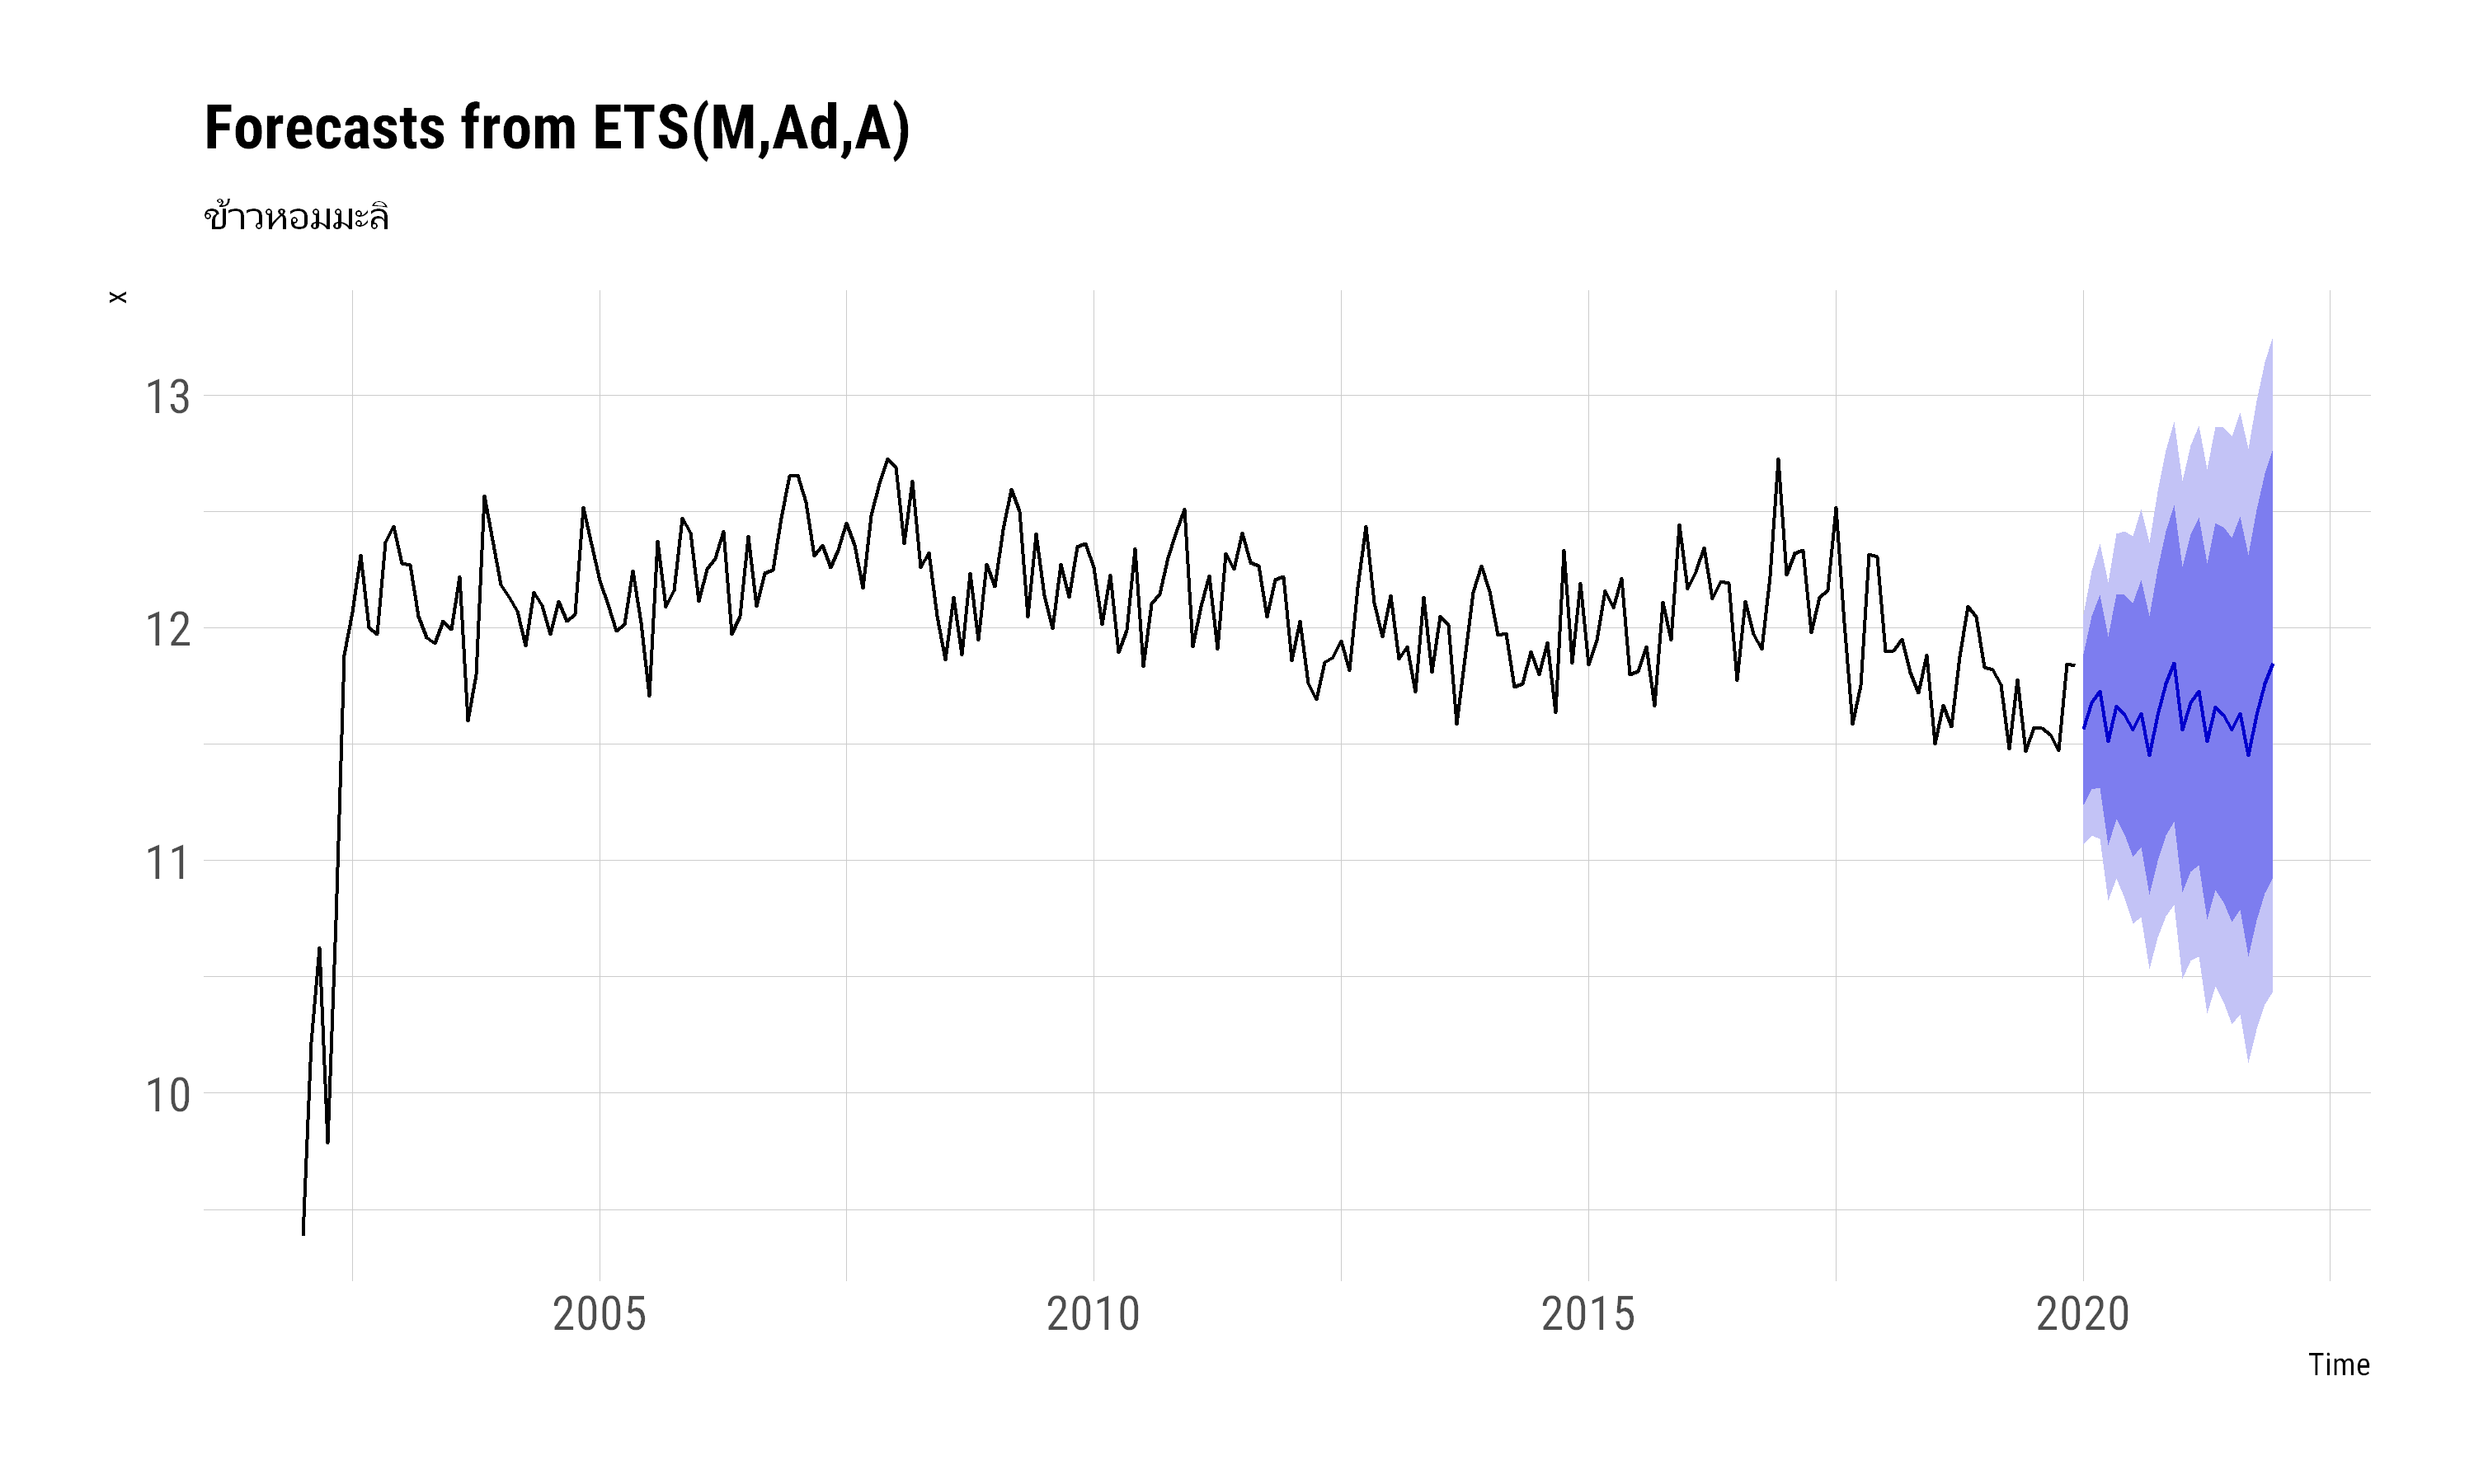

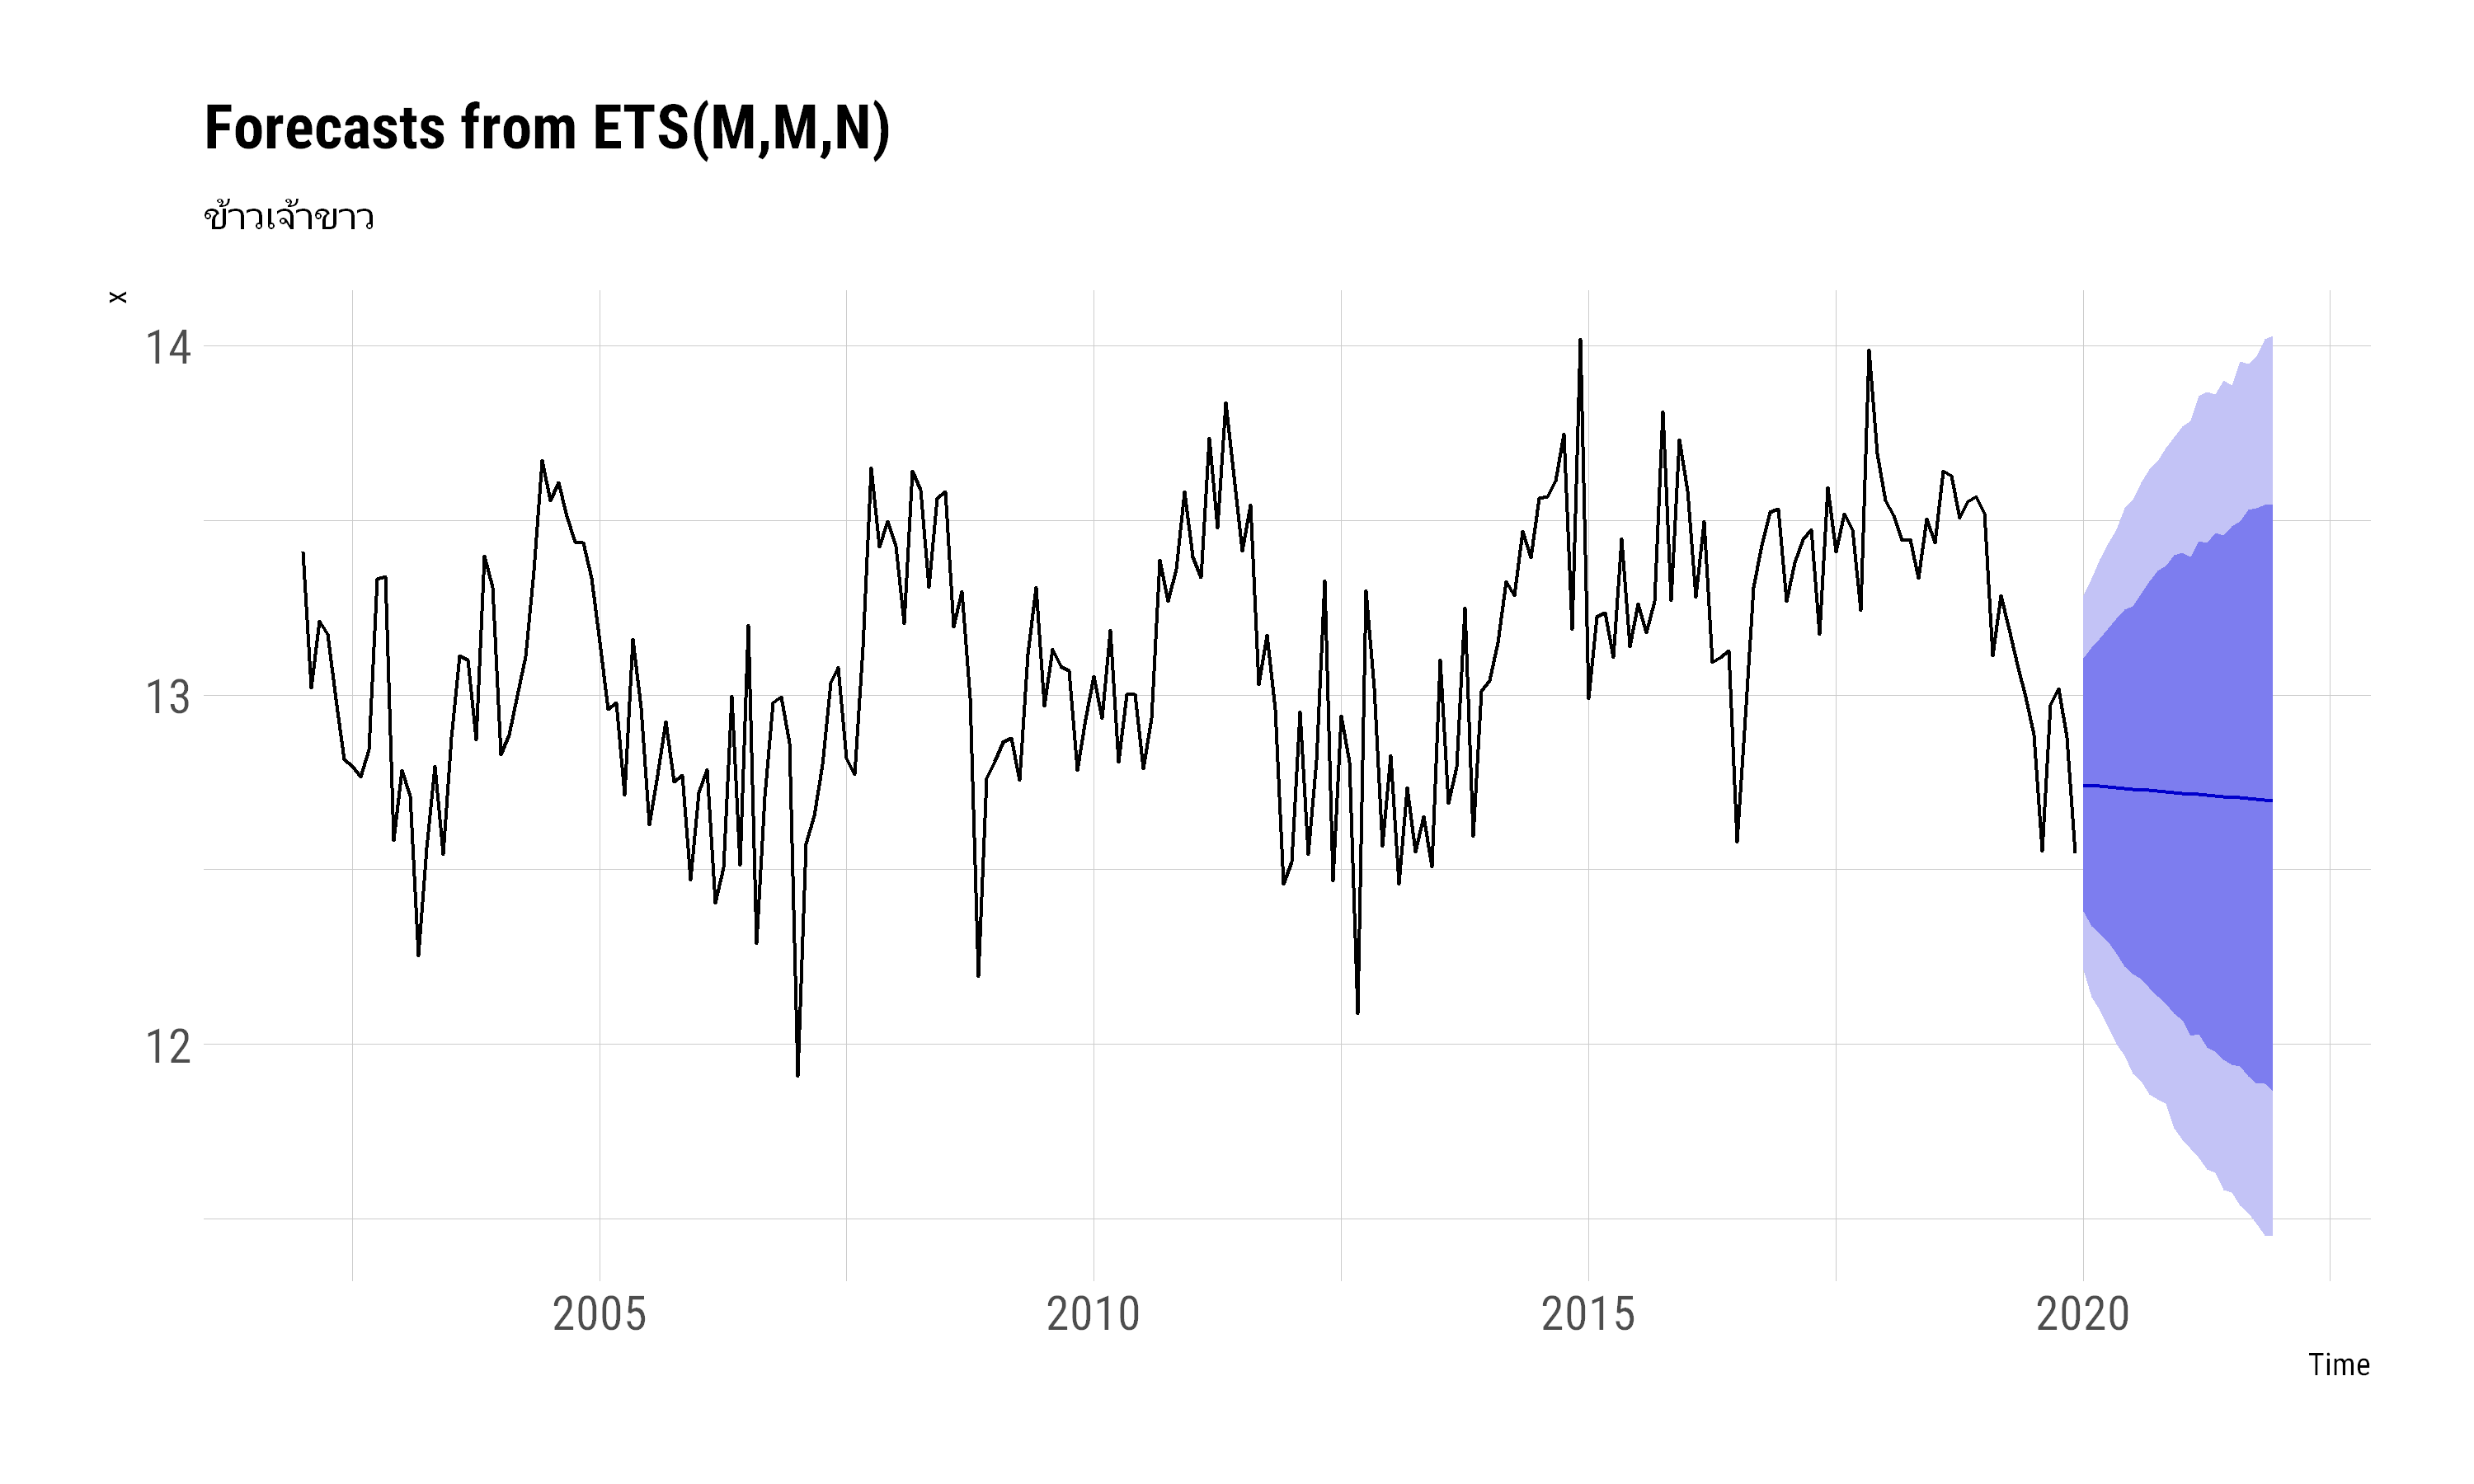

In [67]:
fets(ex_hommali %>% log(), model = 'MAA', damped = TRUE, h = 24) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวหอมมะลิ')
ggsave('../figures/plot_ets_hommali_ex.png', width = 10, height = 5)


fets(ex_white %>% log(), model = 'MMN', damped = FALSE, h = 24) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวเจ้าขาว')
ggsave('../figures/plot_ets_white_ex.png', width = 10, height = 5)

In [68]:
fets(ex_hommali %>% log(), model = 'MAA', damped = TRUE, h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_hml.csv')

fets(ex_white %>% log(), model = 'MMN', damped = FALSE, h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_wht.csv')

# farima(ex_pathum %>% log(), 
#        order = c(1,0,1), seasonal = c(1,0,1), h = 24) %>%
#   as.data.frame() %>%
#   write_excel_csv('../results/export_pat.csv')


# farima(ex_glutinous %>% log(), 
#        order = c(2,0,1), 
#        seasonal = c(1,0,1), h = 24) %>%
#   as.data.frame() %>%
#   write_excel_csv('../results/export_glu.csv')

In [ ]:
fets(log(ts_export[,'ex_hommali']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_ets_exp_hml.png', width = 8, height = 5)

fets(log(ts_export[,'ex_pathum']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_ets_exp_pat.png', width = 8, height = 5)

fets(log(ts_export[,'ex_white']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_ets_exp_wht.png', width = 8, height = 5)

fets(log(ts_export[,'ex_glutinous']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_ets_exp_glu.png', width = 8, height = 5)

## ARIMA

In [ ]:
farima <- function(x, d, h=2) {
  forecast(auto.arima(x, d=d), h=h)
}

In [ ]:
farima(log(data$dom_hommali), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_arima_dom_hml.png', width = 8, height = 4)

farima(log(data$dom_pathum), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_arima_dom_pat.png', width = 8, height = 4)

farima(log(data$dom_white), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_arima_dom_wht.png', width = 8, height = 4)

farima(log(data$dom_glutinous), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_arima_dom_glu.png', width = 8, height = 4)

In [ ]:
farima(log(ts_export[, 'ex_hommali']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_arima_exp_hml.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_pathum']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_arima_exp_pat.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_white']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_arima_exp_wht.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_glutinous']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_arima_exp_glu.png', width = 8, height = 4)

In [ ]:
# Compute CV errors for ETS as e1
e1 <- tsCV(log(data$dom_hommali), fets, h=2, initial = 10)
# Compute CV errors for ARIMA as e2
e2 <- tsCV(log(data$dom_hommali), farima, d=1, h=2, initial = 10)

# MSE
# sqrt(mean(e1[10:13,]^2))
# sqrt(mean(e2[10:13,]^2))

# # MAE
# mean(abs(e1[10:13,]))
# mean(abs(e2[10:13,]))

In [ ]:
forecast(ets(log(data$ex_hommali)), h = 2)

In [ ]:
forecast(auto.arima(log(data$dom_glutinous), d = 1), h = 2) %>% autoplot()

## VAR

In [89]:
gdppc2 = gdppc ** 2

In [177]:
endo = ts_c(ex_hommali, ex_white, p_h100_th, p_w5_th, p_w5_vn)
exo = ts_c(gdppc, gdppc2, pop)
class(exo)

[1] "mts"    "ts"     "matrix"

In [198]:
# endo[, "ex_hommali"] %>% stats::lag()

In [178]:
VARselect(endo, exogen = exo)

,1,2,3,4,5,6,7,8,9,10
AIC(n),-2.411883e+01,-2.460445e+01,-2.460522e+01,-2.449660e+01,-2.441293e+01,-2.434561e+01,-2.438279e+01,-2.437034e+01,-2.437668e+01,-2.429026e+01
HQ(n),-2.382482e+01,-2.414711e+01,-2.398454e+01,-2.371258e+01,-2.346557e+01,-2.323491e+01,-2.310876e+01,-2.293296e+01,-2.277597e+01,-2.252621e+01
SC(n),-2.339187e+01,-2.347362e+01,-2.307052e+01,-2.255803e+01,-2.207049e+01,-2.159931e+01,-2.123262e+01,-2.081630e+01,-2.041877e+01,-1.992848e+01
FPE(n),3.353102e-11,2.064799e-11,2.066467e-11,2.309773e-11,2.521668e-11,2.713019e-11,2.634679e-11,2.695272e-11,2.713396e-11,3.006649e-11


In [107]:
ca.jo(endo, ecdet = 'const', K = 2) %>% summary()


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  2.539564e-01  2.408708e-01  1.172973e-01  4.312912e-02  3.226258e-02
[6] -2.775932e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 4 |  7.02  7.52  9.24 12.97
r <= 3 |  9.43 13.75 15.67 20.20
r <= 2 | 26.70 19.77 22.00 26.81
r <= 1 | 58.97 25.56 28.14 33.24
r = 0  | 62.70 31.66 34.40 39.79

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              ex_hommali.l2 ex_white.l2 p_h100_th.l2  p_w5_th.l2 p_w5_vn.l2
ex_hommali.l2      1.000000   1.0000000     1.000000   1.0000000  1.0000000
ex_white.l2       -2.673236   0.8153670    -5.200744   0.4034286 -0.3821251
p_h100_th.l2       1.010193   0.3468922     6.229011   5.2071079 -3.8531702
p_w5_th.l2        -9.325672   1.9521473     9.012842 -14.970704

In [203]:
# subset(endo, end = 180)

In [199]:
var_fitted = VAR(
  endo, 
  p = 2, 
  type = "const", 
  exogen = exo)

In [109]:
serial.test(vecm_export, lags.pt=12, type="PT.asymptotic")


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_export
Chi-squared = 313.84, df = 250, p-value = 0.003771

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_export
Chi-squared = 313.84, df = 250, p-value = 0.003771



In [176]:
vecm_export[['varresult']][['ex_hommali']]


Call:
lm(formula = y ~ -1 + ., data = datamat)

Coefficients:
ex_hommali.l1    ex_white.l1   p_h100_th.l1     p_w5_th.l1     p_w5_vn.l1  
       0.4350        -0.1344        -1.0062         0.1538         0.9983  
ex_hommali.l2    ex_white.l2   p_h100_th.l2     p_w5_th.l2     p_w5_vn.l2  
       0.1274         0.1087         0.9347        -0.2242        -0.9118  
        const          gdppc         gdppc2            pop  
     -89.3222        22.3329        -1.2350        -0.2452  


In [144]:
forecast(vecm_export, h = 1, exogen = exo[216]) %>% autoplot()
# ggsave('../figures/plot_vecm_exp.png', width = 14, height = 8)

ERROR: Error in predict.varest(object, n.ahead = h, ci = level[i]/100, ...): 
No matrix for dumvar supplied, but object varest contains exogenous variables.

